In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import h5py
import pandas as pd
import csv

import innvestigate

from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

from utils import load_nifti, normalize_float, IntensityRescale, replace_classifier
from plotting import *
from config import *

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "6"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/"

In [5]:
# load hdf5 including edss
train_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_with_edss.h5', 'r')
holdout_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_with_edss.h5', 'r')

X_train, y_train, edss_train = train_h5['X'], train_h5['y'], train_h5["edss"]
X_holdout, y_holdout, edss_holdout = holdout_h5['X'], holdout_h5['y'], holdout_h5["edss"]

train_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [6]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [7]:
# load downsampled atlases
atlas_labels_path = "/analysis/fabiane/scaled_nmm_order0.nii"
atlas_labels = load_nifti(atlas_labels_path)

wm_atlas_path = "/analysis/fabiane/scaled_JHU_WM_order0.nii"
wm_atlas = load_nifti(wm_atlas_path)

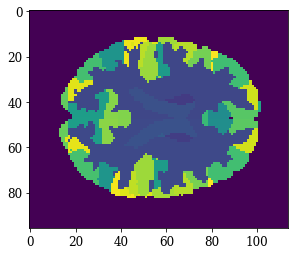

In [8]:
plt.imshow(atlas_labels[:,:,48])
plt.show()

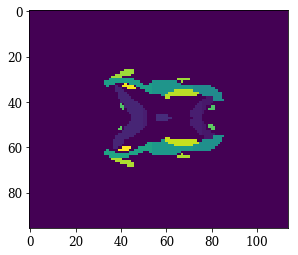

In [9]:
plt.imshow(wm_atlas[:,:,48])
plt.show()

In [10]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None, include_arbtr=False, **kwargs):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        self.include_arbtr = include_arbtr
        if include_arbtr:
            self.kwargs = kwargs["edss"]
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        if not self.include_arbtr:
            return image, label
        else:
            arbtr = self.kwargs[idx * self.batch_size:(idx + 1) * self.batch_size]
            return image, label, arbtr
    
    def on_epoch_end(self):
        if self.shuffle:
            if not self.include_arbtr:
                self.X, self.y = shuffle(self.X, self.y)
            else:
                self.X, self.y, self.kwargs = shuffle(self.X, self.y, self.kwargs)

## Make dataset

In [11]:
intensity = IntensityRescale(masked=False)

In [12]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


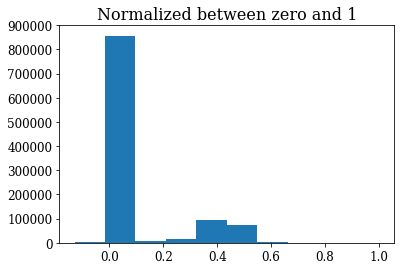

In [13]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


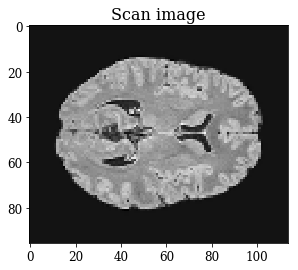

In [14]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

In [15]:
lesion_masks_train.shape

(124, 96, 114, 96)

# Model

In [16]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [17]:
# load model weights
model_path = "/analysis/fabiane/models/ADNI/explMS/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [18]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [19]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [20]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


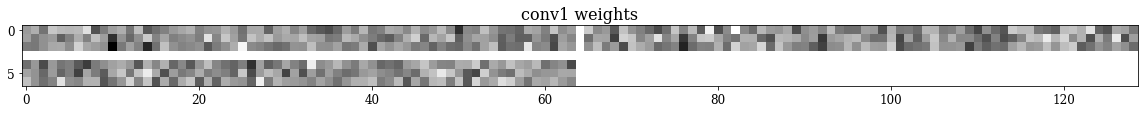

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0006034862017259002


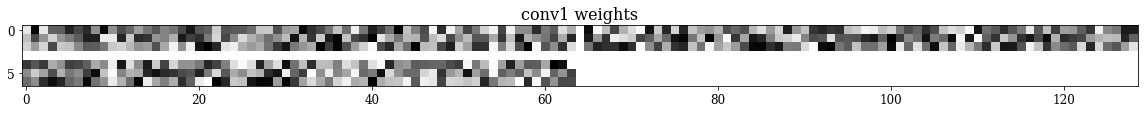

In [21]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

# Visualization

In [22]:
def plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis):
    r = 2
    c = 2
    # Displaying the gradient
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(hspace=0.15, wspace=0.)
    ax1 = plt.subplot(r, c, 1)
    plt.imshow(X_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Scan")
    ax2 = plt.subplot(r, c, 2)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Lesion mask")
    ax3 = plt.subplot(r, c, 3)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='Reds', alpha=0.6, vmin=0.1)
    plt.title("Lesion mask over scan")
    ax4 = plt.subplot(r, c, 4)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(analysis.squeeze()[:,:,sl], cmap='Reds', interpolation='nearest', alpha=0.6)
    plt.title("Heatmap overlayed")
    plt.show()

In [23]:
num_trials = 10
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [24]:
import keras.layers
import keras.models
import keras.utils

import innvestigate.utils as iutils

# Main part

### Loading different models

In [25]:
# pre-trained model
pre_trained_model = load_model(model_path)
pre_trained_beheaded_model = replace_classifier(pre_trained_model, activation=None, units=1) # use logits

# fine-tuned model
fine_tuned_model = load_model(model_path)
fine_tuned_beheaded_model = replace_classifier(fine_tuned_model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[5]) # select best model
fine_tuned_beheaded_model.load_weights(model_dir)
fine_tuned_model.load_weights(model_dir)

# trained from scratch model
scratch_model = load_model(model_path)
scratch_beheaded_model = replace_classifier(scratch_model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, "MS_from_scratch", weights[2]) # select best model
scratch_beheaded_model.load_weights(model_dir)
scratch_model.load_weights(model_dir)

# un-trained model
random_model = load_model(model_path)
random_beheaded_model = replace_classifier(random_model, activation=None, units=1) # use logits
reset_weights(random_beheaded_model)
reset_weights(random_model)

### Creating special transparent colormap

In [26]:
from matplotlib.colors import LinearSegmentedColormap
def generate_transparanet_cm(base='coolwarm'):
    # copy from existing colormap
    ncolors = 256
    color_array = plt.get_cmap(base)(range(ncolors))

    # create parabolic decrease 
    decr = [-1*(x**2)+1 for x in range(int(ncolors/2))]
    # normalize
    decr = (decr - np.min(decr))/(np.max(decr - np.min(decr)))

    # use inverted parabola as increase
    incr = np.copy(decr)[::-1]
    alphas = np.concatenate((decr, incr))
    # update alpha values
    color_array[:,-1] = alphas

    # create new colormap and register it
    transparent_coolwarm = LinearSegmentedColormap.from_list('TransCoWa', color_array)
    plt.register_cmap(cmap=transparent_coolwarm)

In [27]:
generate_transparanet_cm(base='coolwarm')

### Plotting functions

In [28]:
image_file_dir = "/analysis/fabiane/documents/publications/MS_CNN_VIS"

In [29]:
mask = np.expand_dims(load_nifti("/analysis/ritter/data/MS/Test/alt/zoomed_mask2.nii.gz", z_factor=z_factor), 3)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [30]:
mask[mask <1e-5] = 0.0

In [31]:
test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [32]:
train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [33]:
def plot_heatmap(heatmap, scan_avg, vmin, vmax, title="Heatmap sum", cmap='seismic', sl=(48, 60, 48), show_average=True):
    vmin = -0.05
    vmax = 0.05

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,:,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 2)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 3)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[sl[2],:,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.show()

In [34]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap2(heatmap, scan_avg, vmin, vmax, title=None, cmap='seismic', sl=((48, 60, 48),), show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of entire individual by iterating over
    slice combinations.
    """
    vmin = -0.03
    vmax = 0.03
    sl_list = list(sl)
    nrows = len(sl_list)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.49, 4.5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]

    for count, sl in enumerate(sl_list):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.05, 0.01, p2[2], 0.01]) # settings for whole subject
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)   
        
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [35]:
def plot_heatmap_zero_one(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.08, 0.07, p2[2], 0.03]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
    
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [36]:
from decimal import *

In [37]:
def get_heatmap_sum(dataloader, shape, beheaded_model, prediction_model, mode='prediction', as_list=False):
    """
    Return the total heatmap sum of all subjects within the dataset.
    In the code "one_" stands for prediction class and "zero_" for null class.
    
    Arguments
        mode: Can be one of 'prediction' or 'label'. Former separates
            true positives and true negatives (ignores false
            predictions), latter separates only by label.
        
    """
    if not as_list:
        one_heatmaps = np.zeros(shape=shape)
        zero_heatmaps = np.zeros(shape=shape)
    else:
        one_heatmaps = []
        zero_heatmaps = []
        
    def add_hm(hm, analysis):
        if not as_list:
            hm += analysis
        else:
            hm.append(analysis)
            
    one_count = 0
    zero_count = 0
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        pred = (prediction_model.predict(image) > 0.5) * 1.

        # Applying the analyzer
        analysis = gradient_analyzer.analyze(image)
        
        if mode == 'prediction':
            # Sorting by correct predictions
            if label == 1 and pred == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 0 and pred == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        elif mode == 'label':
            # Sorting by label
            if label == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        
    print("Sorted by {}".format(mode))
    print("total {}".format(len(dataloader)))
    print("one {}".format(one_count))
    print("zero {}".format(zero_count))
    # Average values over number of samples
    if not as_list:
        one_heatmaps /= one_count
        zero_heatmaps /= zero_count
    
    return one_heatmaps, zero_heatmaps

In [38]:
def get_heatmap_list(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
    return heatmap_list

In [39]:
def get_heatmap_list_with_edss(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    edss = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        edss_score = dataloader[image_idx][2][[0]].item()
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
            edss.append(edss_score)
    return heatmap_list, edss

# Average heatmaps

In [40]:
ms_heatmaps_holdout, hc_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [41]:
ms_heatmaps_train, hc_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 124
one 63
zero 61


In [42]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [43]:
TP_heatmaps_train, TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 124
one 54
zero 60


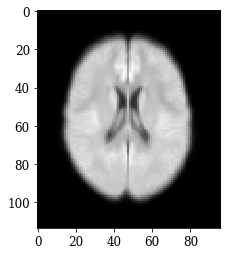

In [44]:
# Create average image for background
avg_train_image = np.mean(X_train, axis=0)
plt.imshow(np.rot90(np.squeeze(avg_train_image)[:,:,48], axes=(0,1)), cmap='gray')
plt.show()

# Holdout averages

### MS vs HC

In [45]:
plt.rc('font', family='serif')

In [46]:
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['serif']))
print(font)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


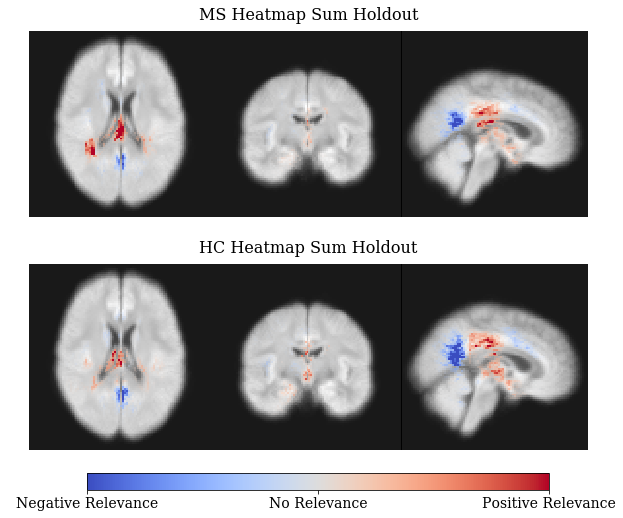

In [47]:
hms = [ms_heatmaps_holdout, hc_heatmaps_holdout]
titles = ["MS Heatmap Sum Holdout", "HC Heatmap Sum Holdout"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

### TP vs TN

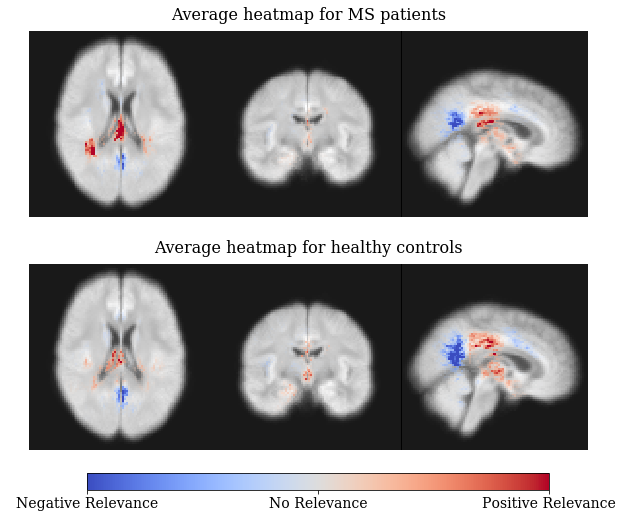

In [48]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
titles = ["Average heatmap for MS patients", "Average heatmap for healthy controls"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_TP_TN_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

# Atlas analysis

## Gray matter atlas

In [49]:
keys, values = get_area_relevance(hms, atlas_labels, gm_areas, positive=True, size_normalize=False)

In [50]:
keys = translate_keys(keys)
df = wrap_as_df(keys, values)
short_df = reduce_df(df, take=30)

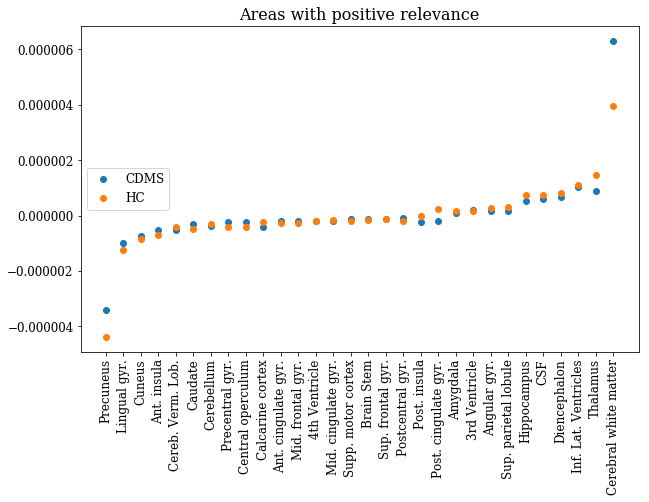

In [51]:
plot_dataframe(short_df, "Areas with positive relevance")

Values normalized

In [52]:
norm_keys, norm_values = get_area_relevance(hms, atlas_labels, gm_areas, positive=True, size_normalize=True)

In [53]:
norm_keys = translate_keys(norm_keys)
norm_df = wrap_as_df(norm_keys, norm_values)
short_norm_df = reduce_df(norm_df, take=30)

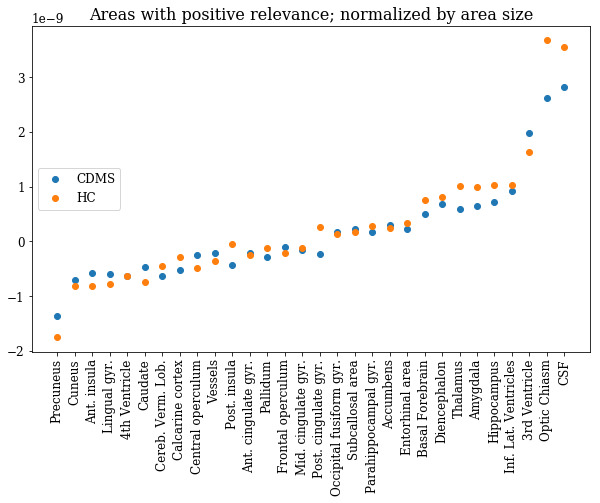

In [54]:
plot_dataframe(short_norm_df, "Areas with positive relevance; normalized by area size")

### Subject wise atlas analysis

In [55]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=True)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=True)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]
            
df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)            

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [56]:
print(np.sum(TP_heatmaps_holdout_list))
print(np.mean(TP_heatmaps_holdout_list))
print(np.std(TP_heatmaps_holdout_list))

38.732132
3.072153e-06
0.0013698384


In [57]:
print(np.sum(TN_heatmaps_holdout_list))
print(np.mean(TN_heatmaps_holdout_list))
print(np.std(TN_heatmaps_holdout_list))

-9.914873
-1.0485697e-06
0.0012700517


In [58]:
short_df_TN, short_df_TP = reduce_two_dfs(df_TN, df_TP, take=30)

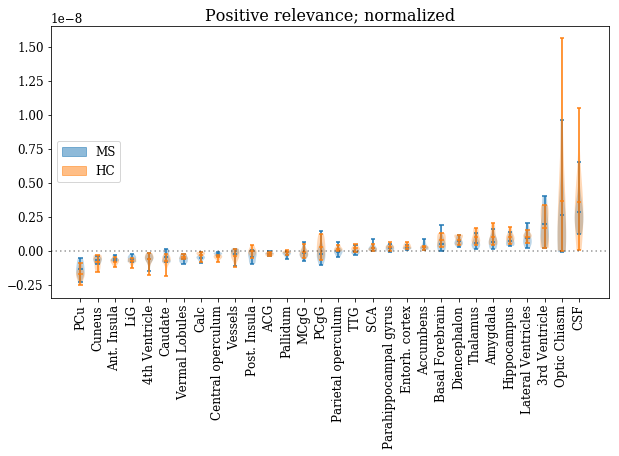

In [59]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)

axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
plt.show()

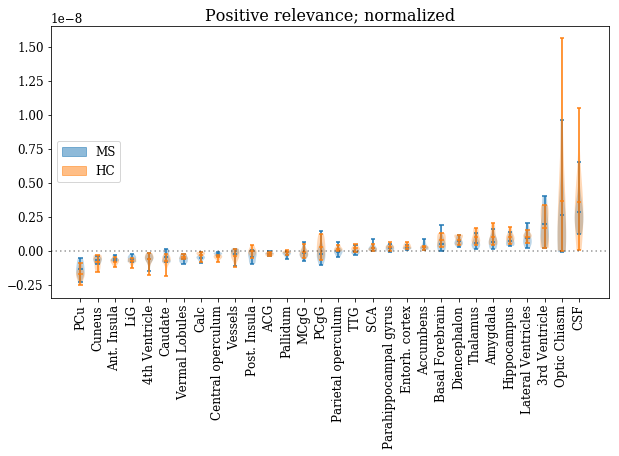

In [60]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)

axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
plt.show()

Not normalized

In [61]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=False)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=False)

keys_TP = translate_keys(keys_TP)
hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]
            
keys_TN = translate_keys(keys_TN)
hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]

df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)        

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [62]:
short_df_TN, short_df_TP = reduce_two_dfs(df_TN, df_TP, take=30)

In [63]:
len(short_df_TP.columns)

30

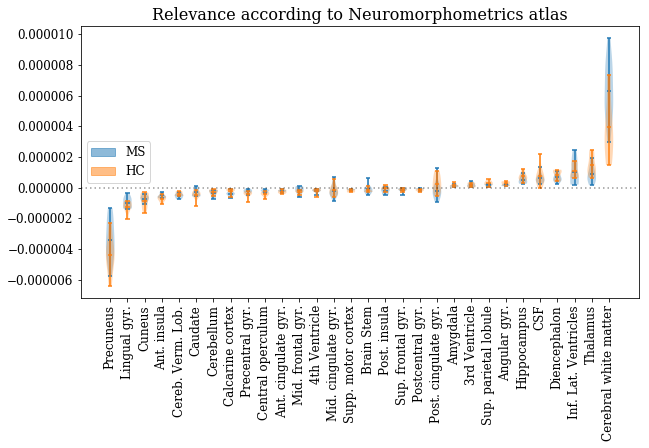

In [64]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)

axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')

ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Relevance according to Neuromorphometrics atlas")
file_path = os.path.join(image_file_dir, "relevance_GM_normal-scans_absolute.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
plt.show()

## White matter atlas

In [65]:
save_for_comparison = False

Positive

In [66]:
keys, values = get_area_relevance(hms, wm_atlas, wm_areas, positive=True, size_normalize=False)

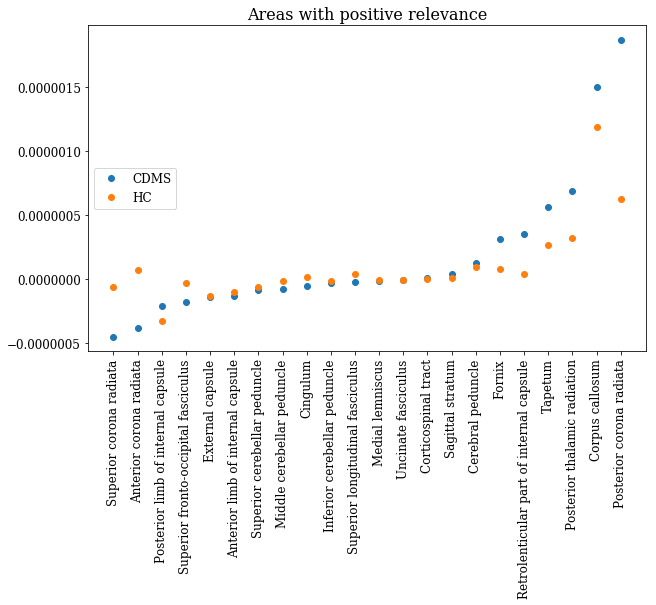

In [67]:
plot_key_value_pairs(keys, values, "Areas with positive relevance")

In [68]:
if save_for_comparison:
    # save positive not normalized values for comparison
    with open("/analysis/ritter/projects/MS/interm_results/evidence_in_area-absolute-TP-normal_images.csv", 'w') as file:
        wr = csv.writer(file)
        wr.writerow(["area", "relevance"])
        for row in zip(keys[0], values[0]):
            wr.writerow(row)

Positive Normalized

In [69]:
norm_keys, norm_values = get_area_relevance(hms, wm_atlas, wm_areas, positive=True, size_normalize=True)

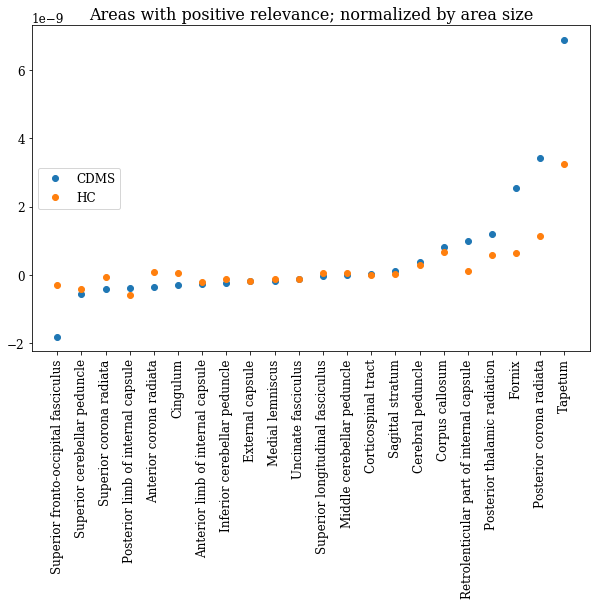

In [70]:
plot_key_value_pairs(norm_keys, norm_values, "Areas with positive relevance; normalized by area size")

In [71]:
if save_for_comparison:
    # save positive normalized values for comparison
    with open("/analysis/ritter/projects/MS/interm_results/evidence_in_area-normalized-TP-normal_images.csv", 'w') as file:
        wr = csv.writer(file)
        wr.writerow(["area", "relevance"])
        for row in zip(norm_keys[0], norm_values[0]):
            wr.writerow(row)

### Subject wise atlas analysis

In [72]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=True)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=True)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]
            
df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


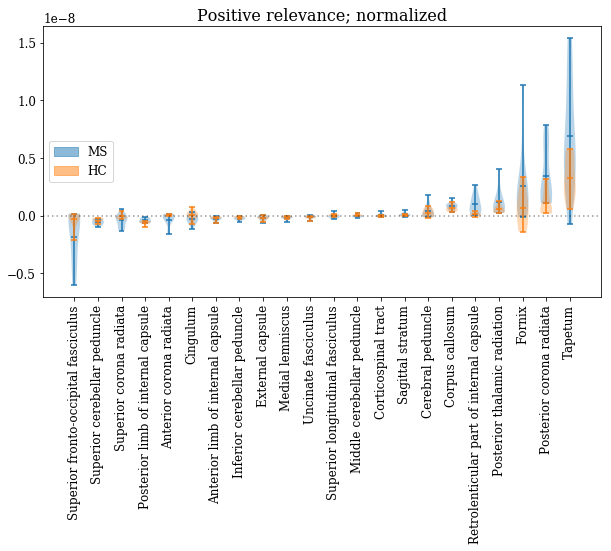

In [73]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[df_TP[key].values.astype(np.float) for key in norm_keys[0]], showmeans=True)
axes.violinplot(dataset=[df_TN[key].values.astype(np.float) for key in norm_keys[0]], showmeans=True)

axes.set_xticks(range(1, len(df_TP.columns)+1))
axes.set_xticklabels([key for key in norm_keys[0]])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")

axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
file_path = os.path.join(image_file_dir, "relevance_WM_normal-scans_normalized.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
plt.show()

Not normalized

In [74]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=False)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=False)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]

df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


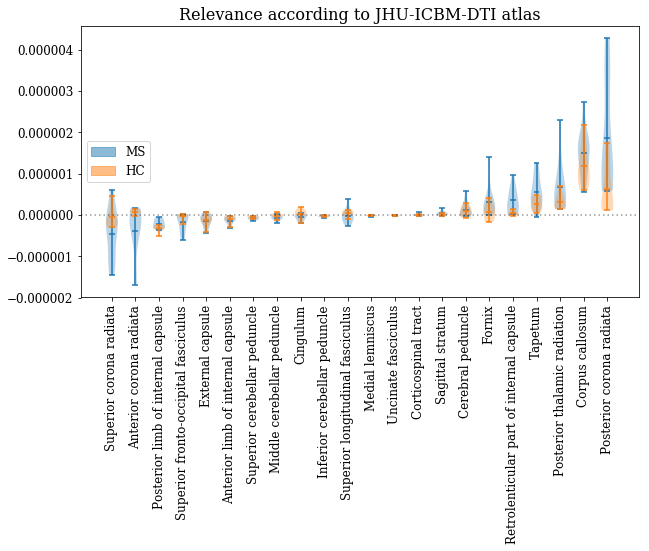

In [75]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[df_TP[key].values.astype(np.float) for key in keys[0]], showmeans=True)
axes.violinplot(dataset=[df_TN[key].values.astype(np.float) for key in keys[0]], showmeans=True)

axes.set_xticks(range(1, len(df_TP.columns)+1))
axes.set_xticklabels([key for key in keys[0]])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")

axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Relevance according to JHU-ICBM-DTI atlas")
file_path = os.path.join(image_file_dir, "relevance_WM_normal-scans_absolute.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')

plt.show()

# Training averages

### MS vs HC

2.1735401158953085


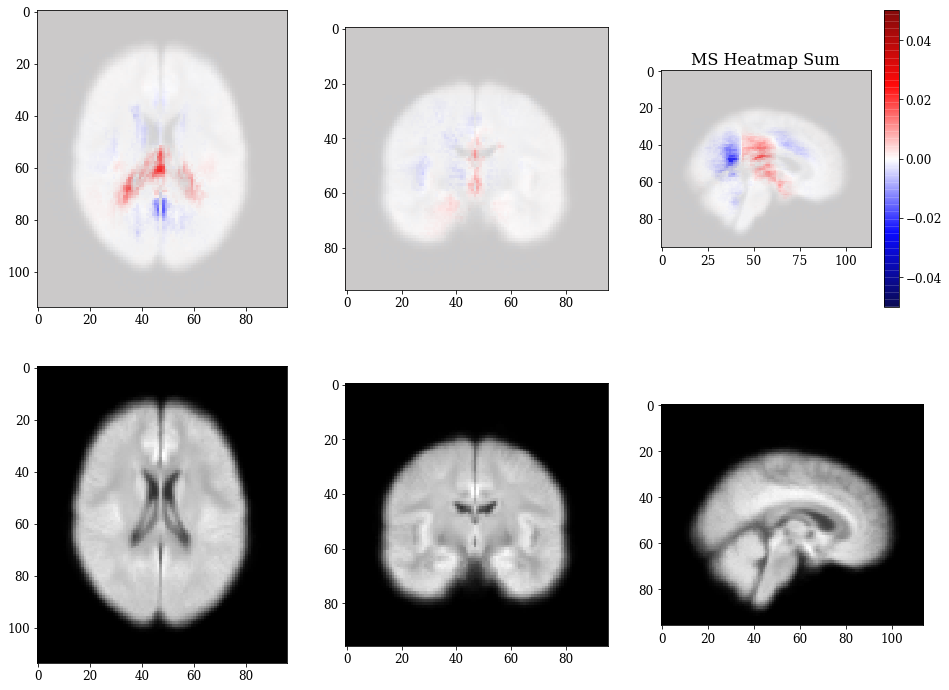

-1.6309956098642697


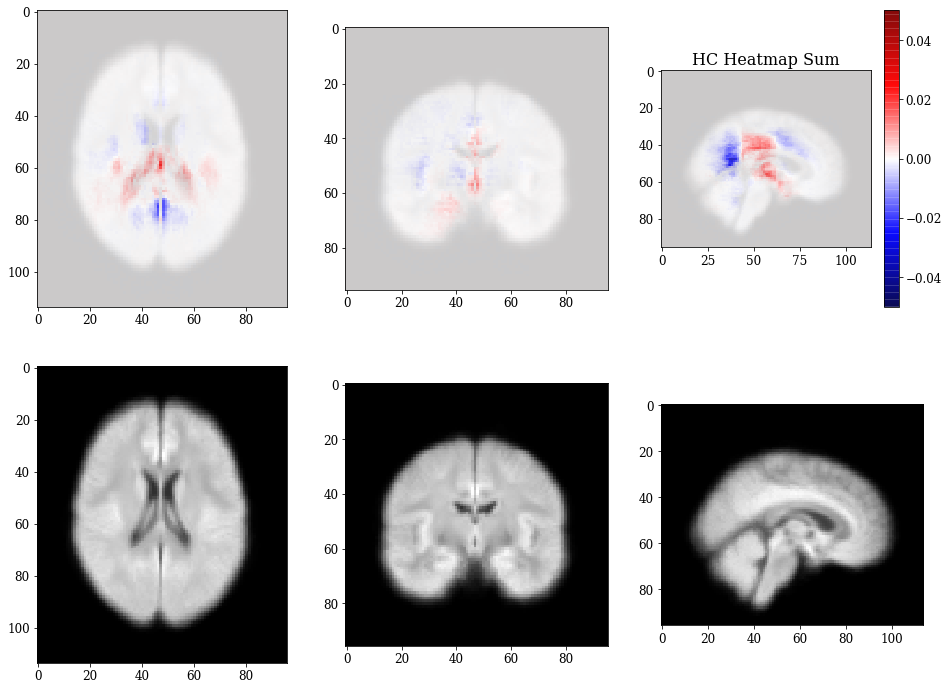

In [76]:
hms = [ms_heatmaps_train, hc_heatmaps_train]
titles = ["MS Heatmap Sum", "HC Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

### TP vs TN

2.653071974110551


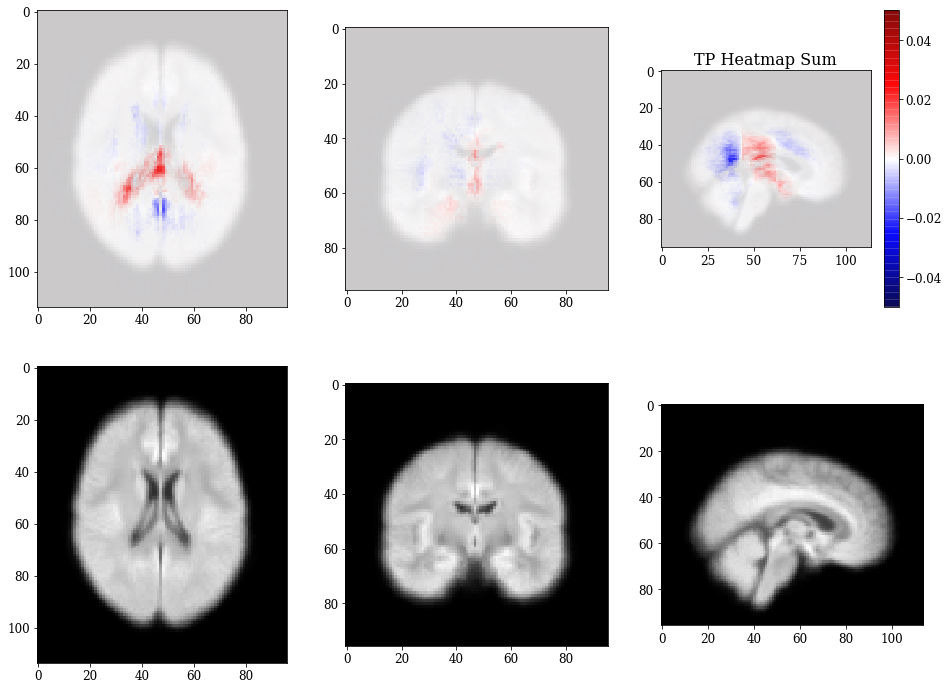

-1.6695644629832935


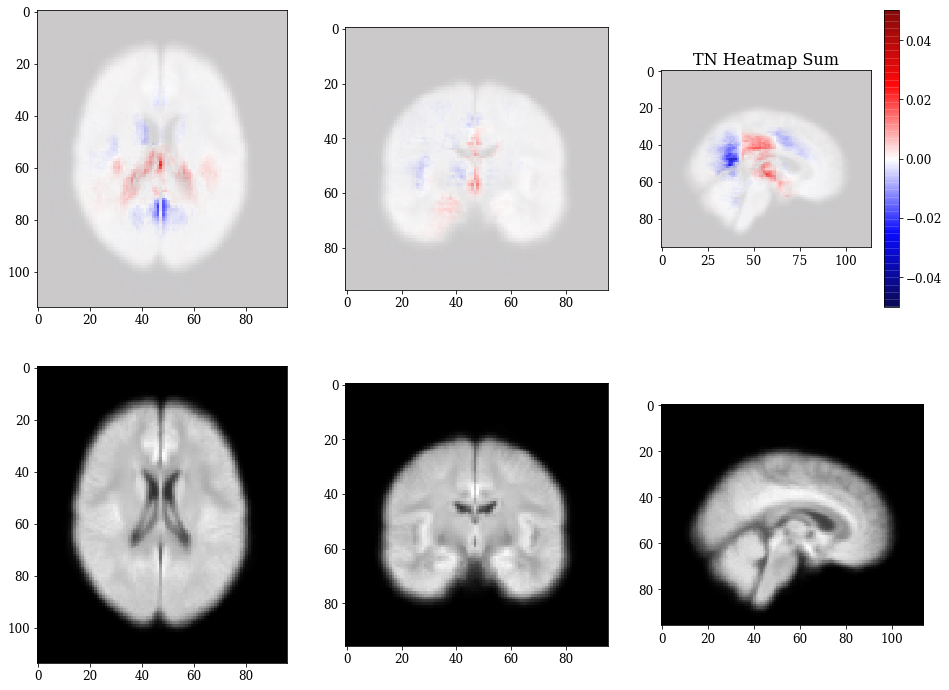

In [77]:
hms = [TP_heatmaps_train, TN_heatmaps_train]
titles = ["TP Heatmap Sum", "TN Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

In [78]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

2.1735401158953085
-1.6309956098642697


In [79]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

2.1735401158953085
-1.6309956098642697


# Visualizing 4 subjects

### MS

In [81]:
# find subjects with highest sigmoid output
scores = []
for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    score = fine_tuned_model.predict(image)
    scores.append(score[0][0])
idx_list = np.argsort(-np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


#########
Index 6
Score 0.996423
#########
Index 4
Score 0.980106
#########
Index 8
Score 0.973384
#########
Index 12
Score 0.970622
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [1.] 
sigmoid score [0.99642295]
beheaded score 5.629638
analysis sum 6.679100


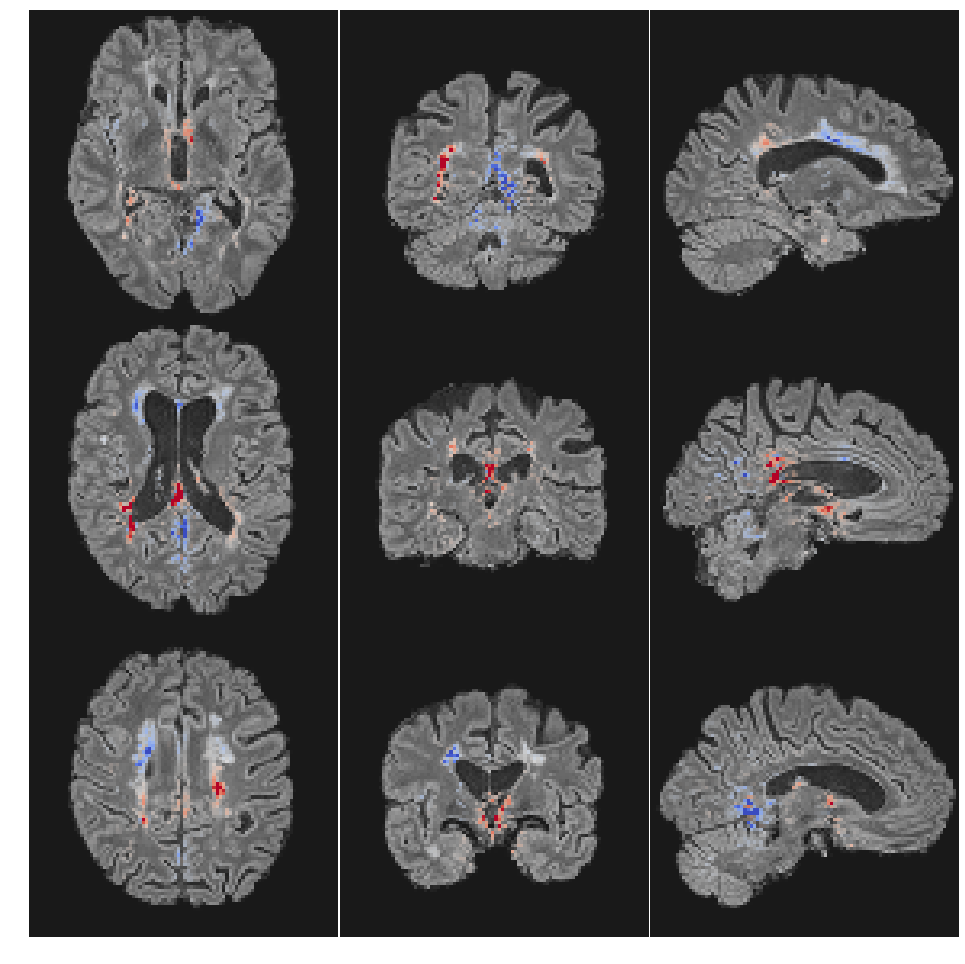

pred [1.] 
sigmoid score [0.9801063]
beheaded score 3.897254
analysis sum 5.314577


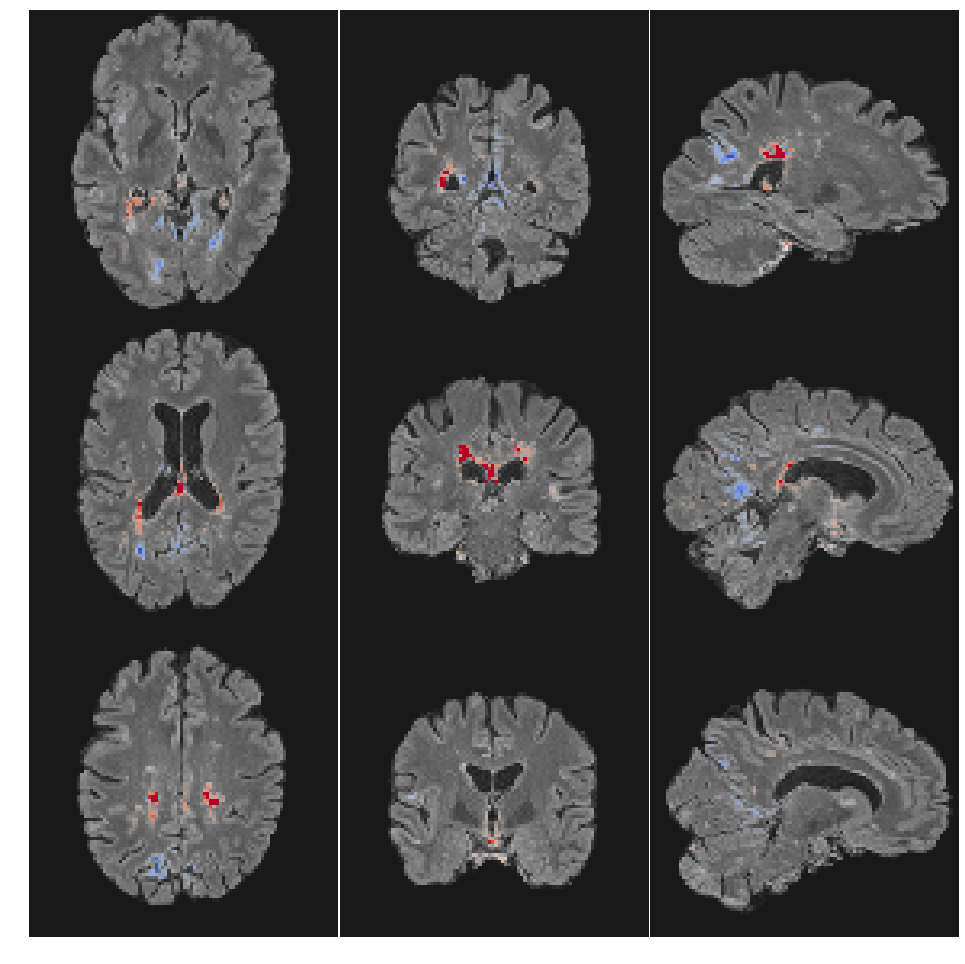

pred [1.] 
sigmoid score [0.97338426]
beheaded score 3.599277
analysis sum 4.413381


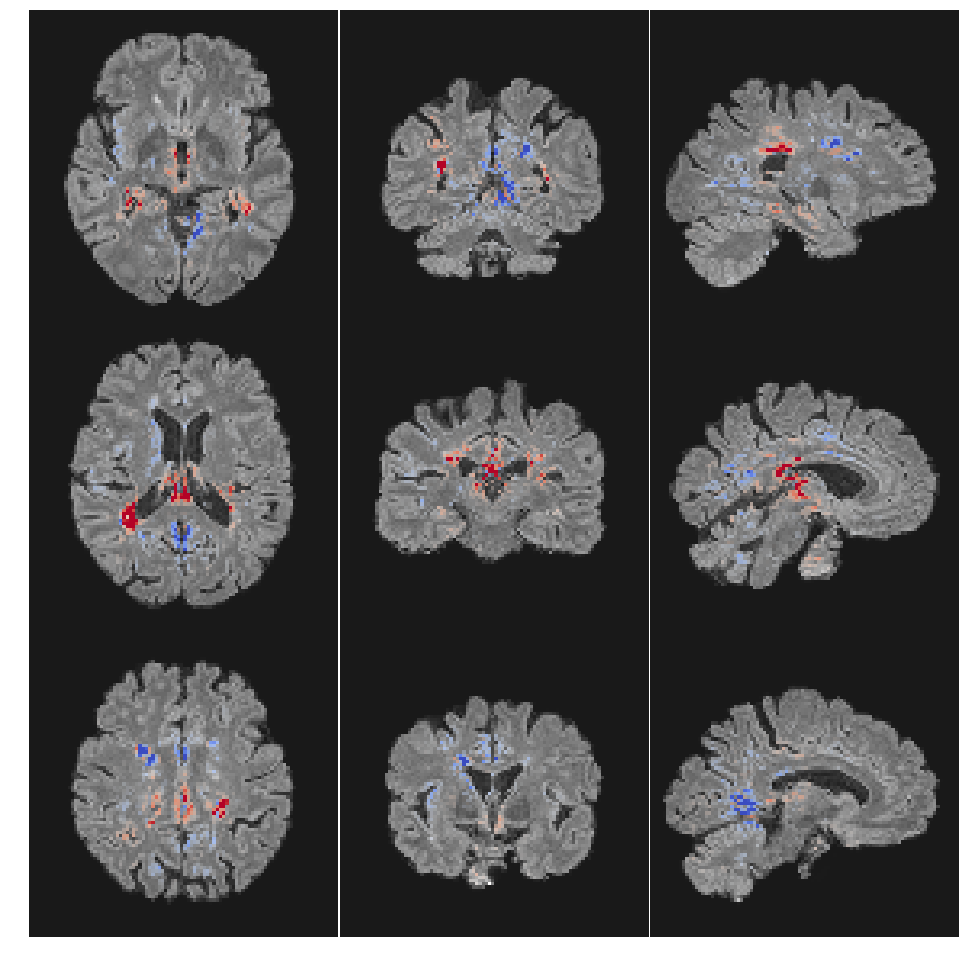

pred [1.] 
sigmoid score [0.9706222]
beheaded score 3.497698
analysis sum 5.073509


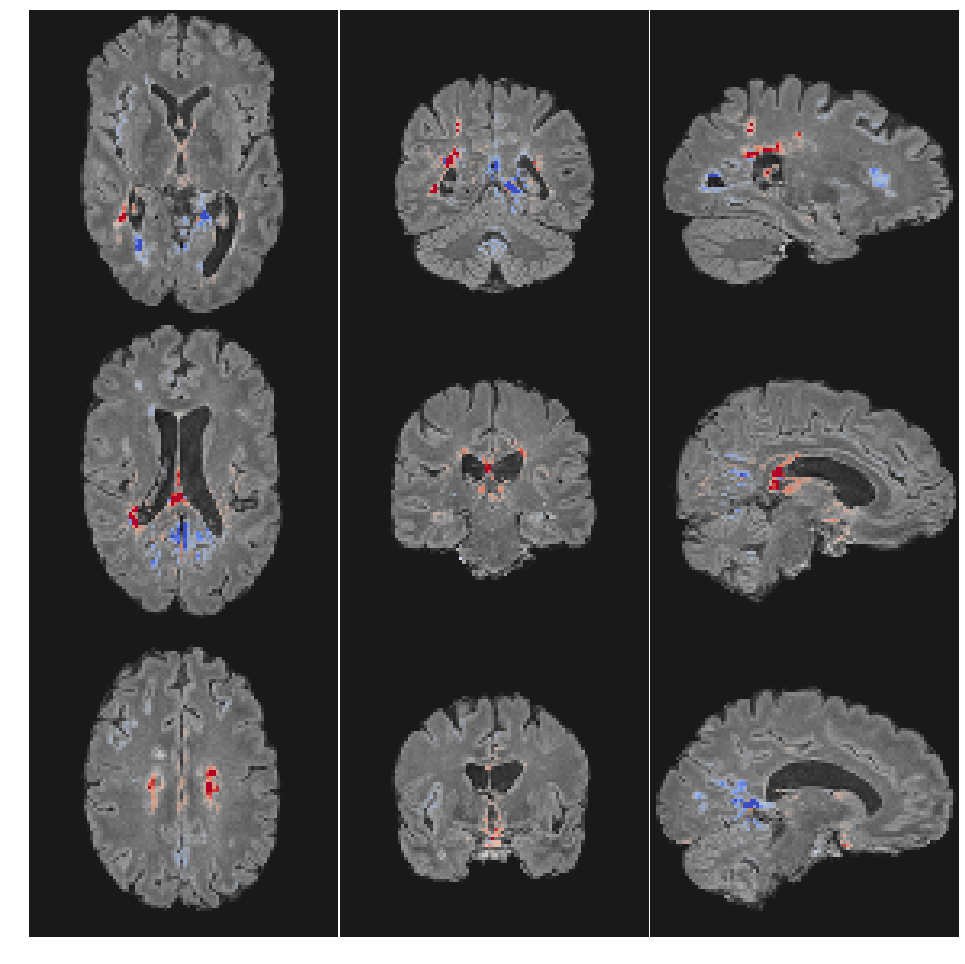

In [82]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "MS_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

### Healthy controls

In [83]:
# get the lowest scores i.e. best classification for HC
idx_list = np.argsort(np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

#########
Index 19
Score 0.098773
#########
Index 3
Score 0.229042
#########
Index 20
Score 0.273408
#########
Index 17
Score 0.276104
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [0.] 
sigmoid score [0.09877317]
beheaded score -2.210931
analysis sum -2.669526


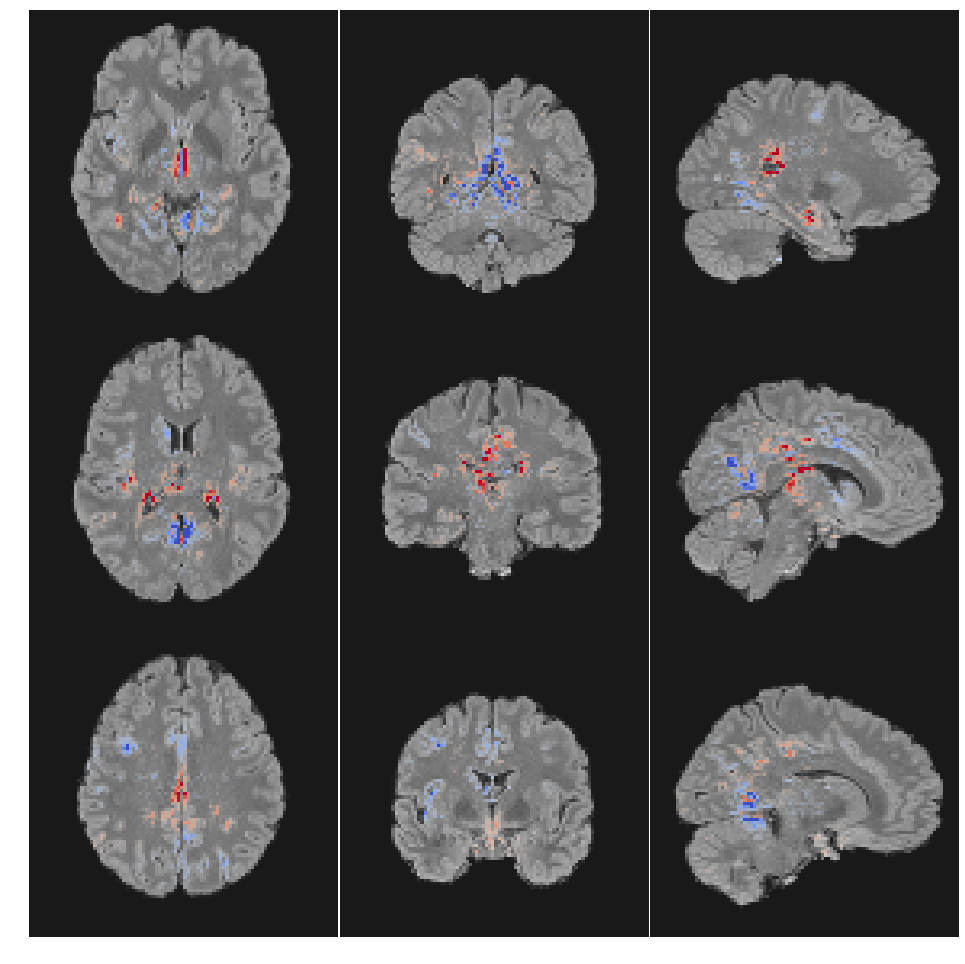

pred [0.] 
sigmoid score [0.2290421]
beheaded score -1.213728
analysis sum -1.658455


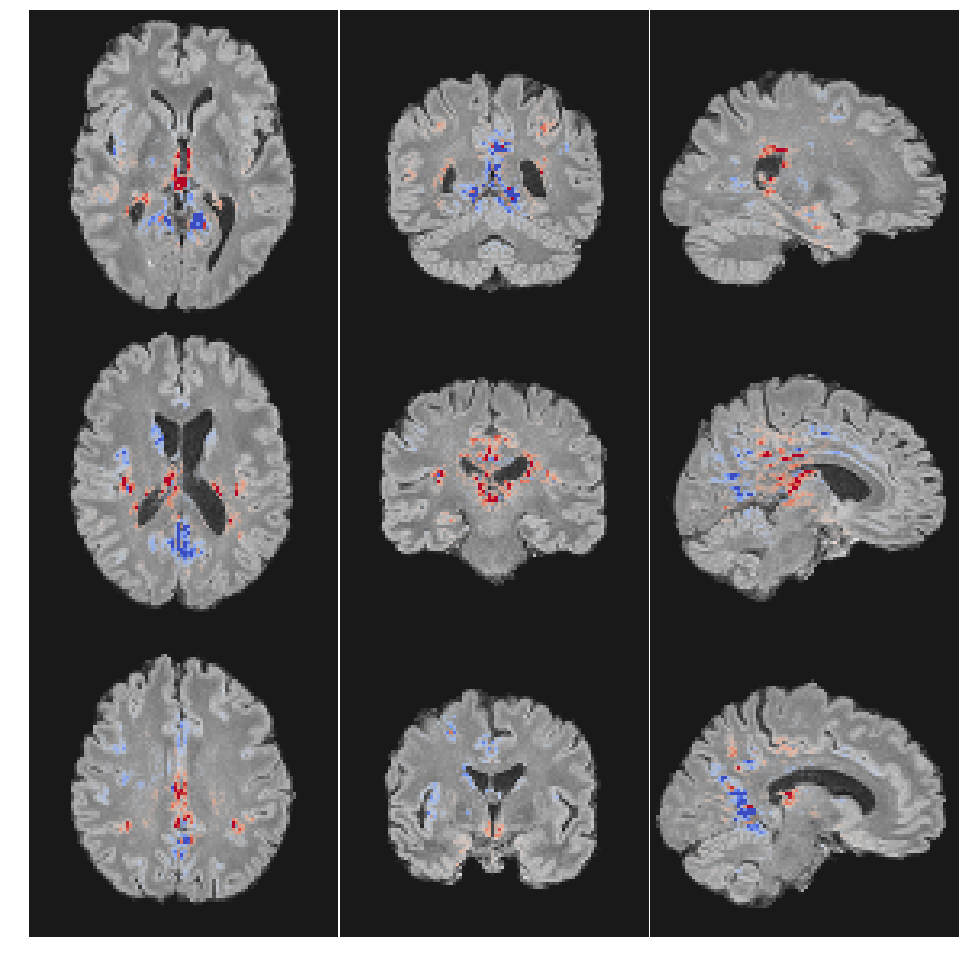

pred [0.] 
sigmoid score [0.27340817]
beheaded score -0.977399
analysis sum -1.177915


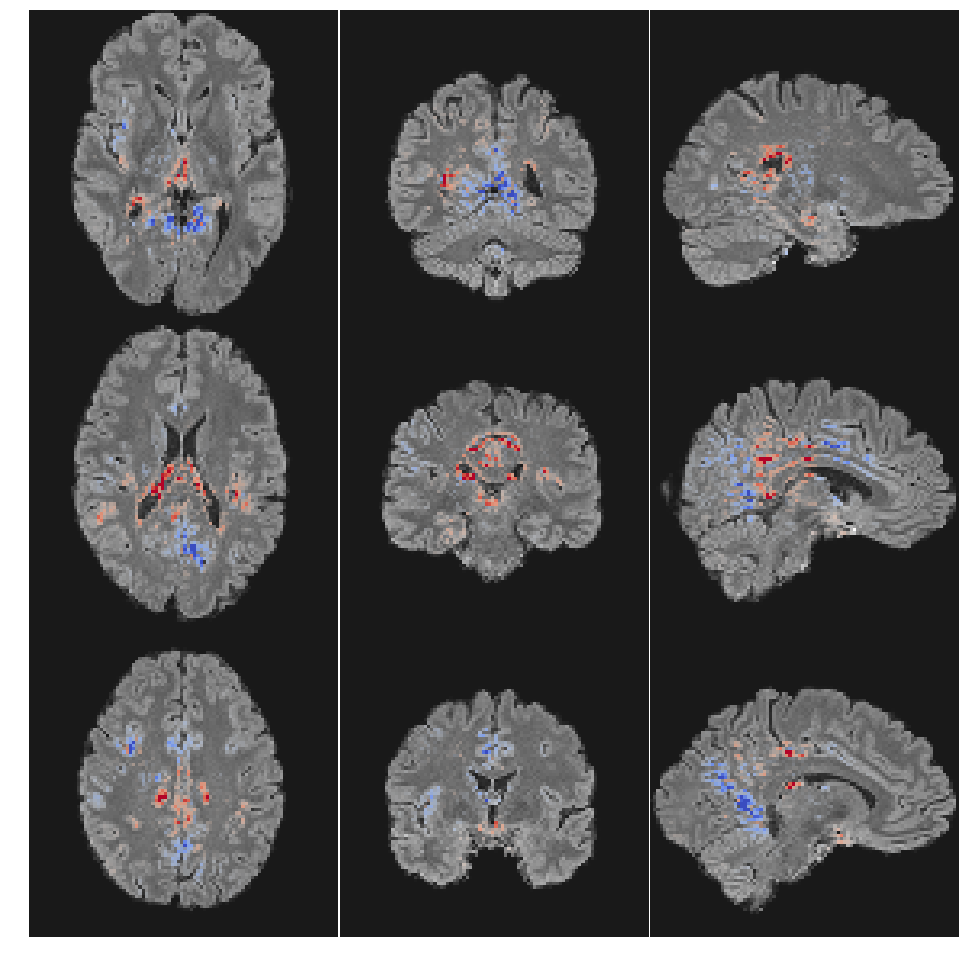

pred [0.] 
sigmoid score [0.27610388]
beheaded score -0.963871
analysis sum -1.569888


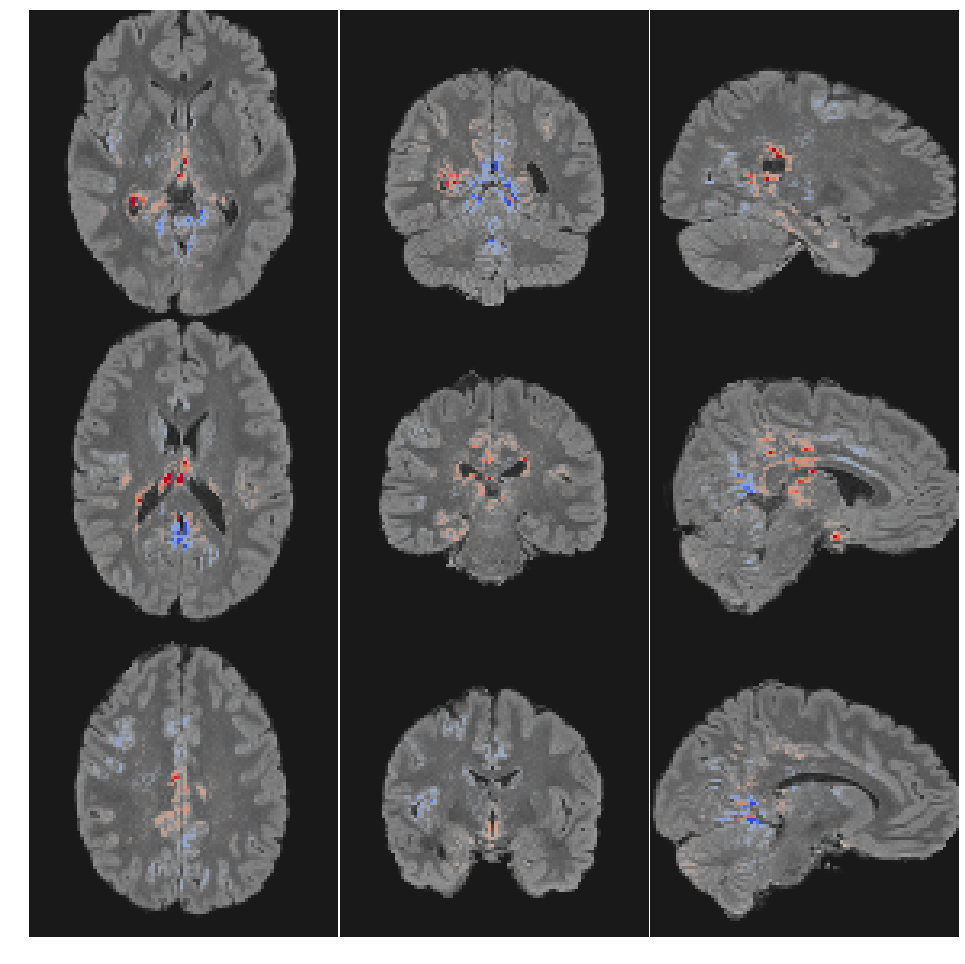

In [84]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "HC_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

# Visualizing all holdout scans

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [1.] 
sigmoid score [0.5888045]
fine_tuned_beheaded score 0.359025
analysis sum 0.920707


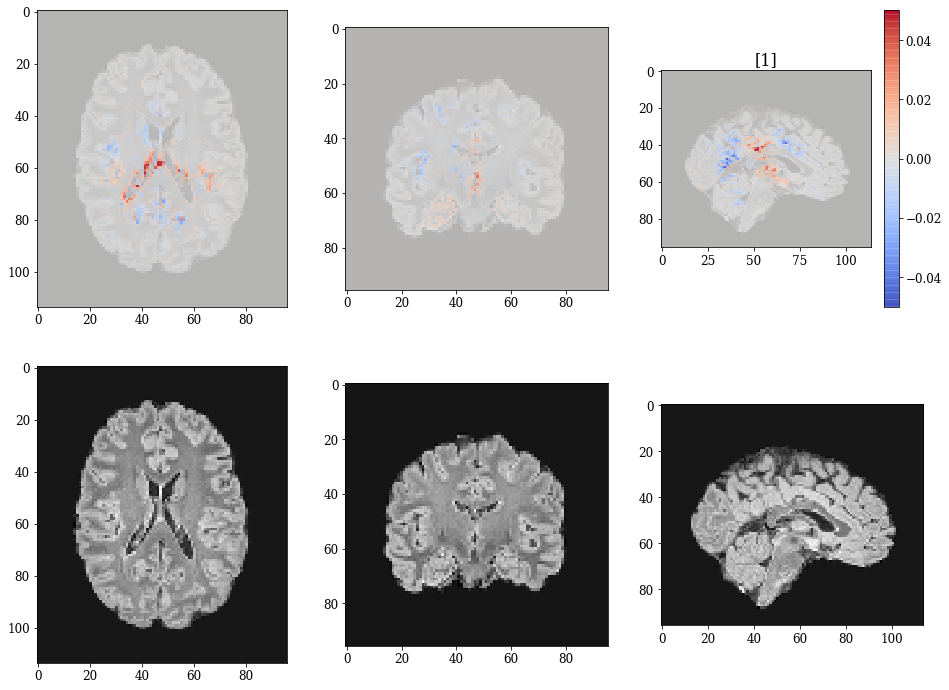

pred [1.] 
sigmoid score [0.63422424]
fine_tuned_beheaded score 0.550382
analysis sum 0.639512


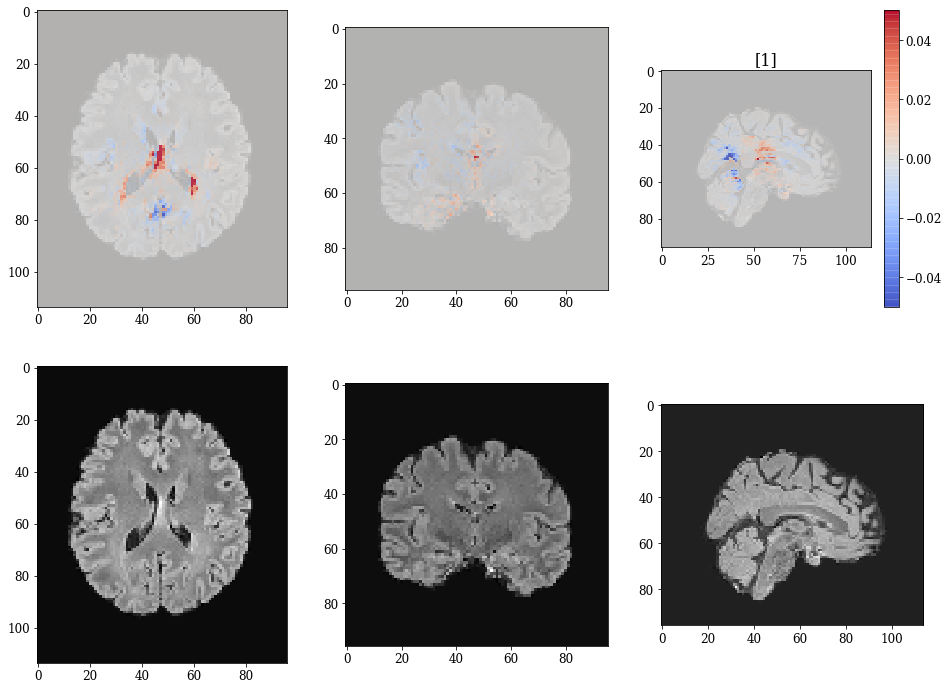

pred [0.] 
sigmoid score [0.3602204]
fine_tuned_beheaded score -0.574408
analysis sum -0.527786


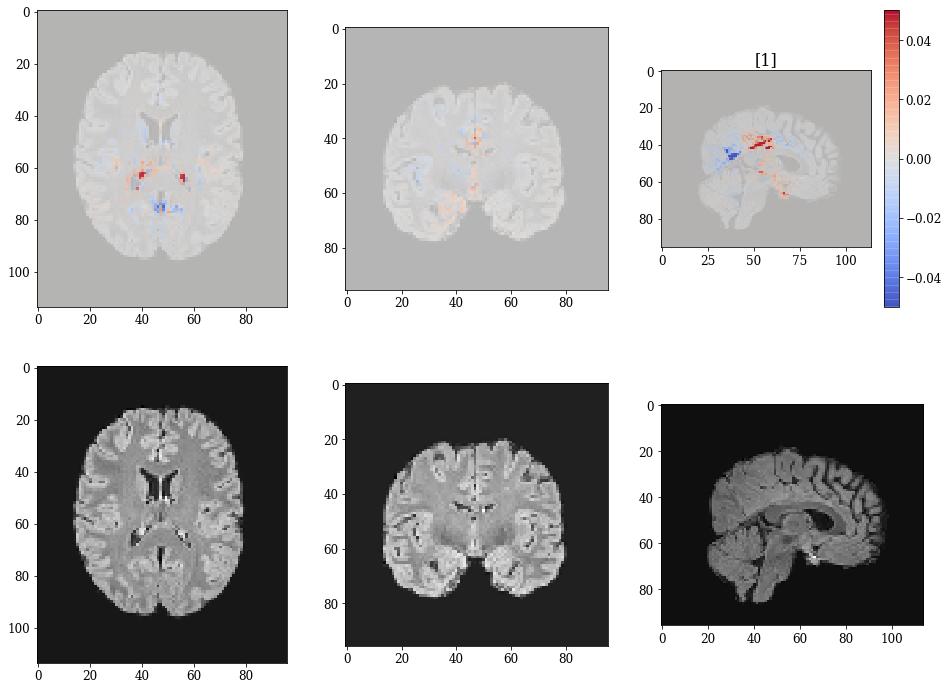

pred [0.] 
sigmoid score [0.2290421]
fine_tuned_beheaded score -1.213728
analysis sum -1.658455


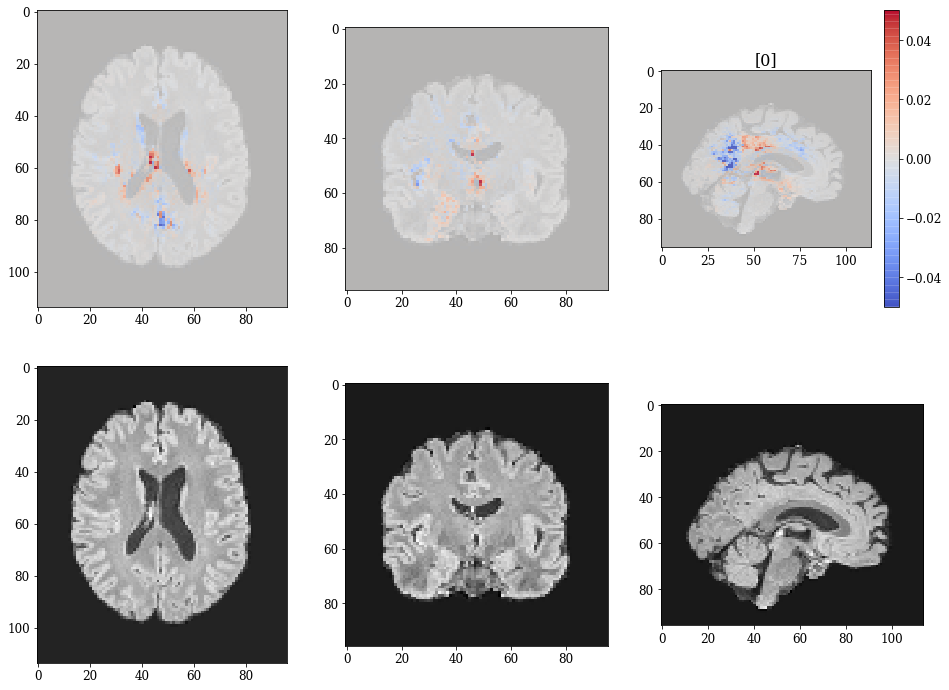

pred [1.] 
sigmoid score [0.9801063]
fine_tuned_beheaded score 3.897254
analysis sum 5.314577


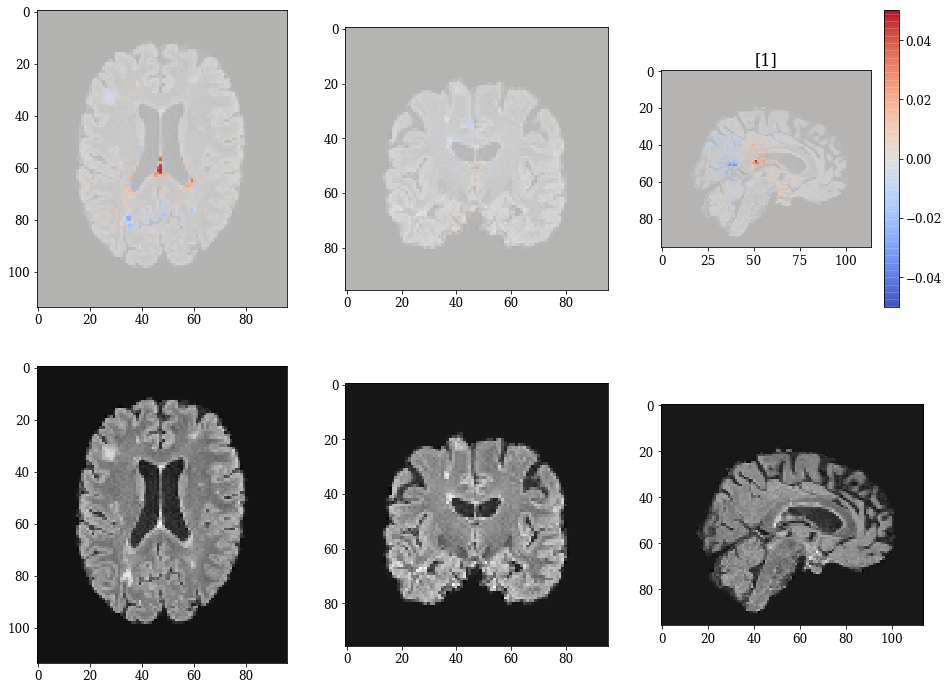

pred [0.] 
sigmoid score [0.28947553]
fine_tuned_beheaded score -0.897933
analysis sum -0.841028


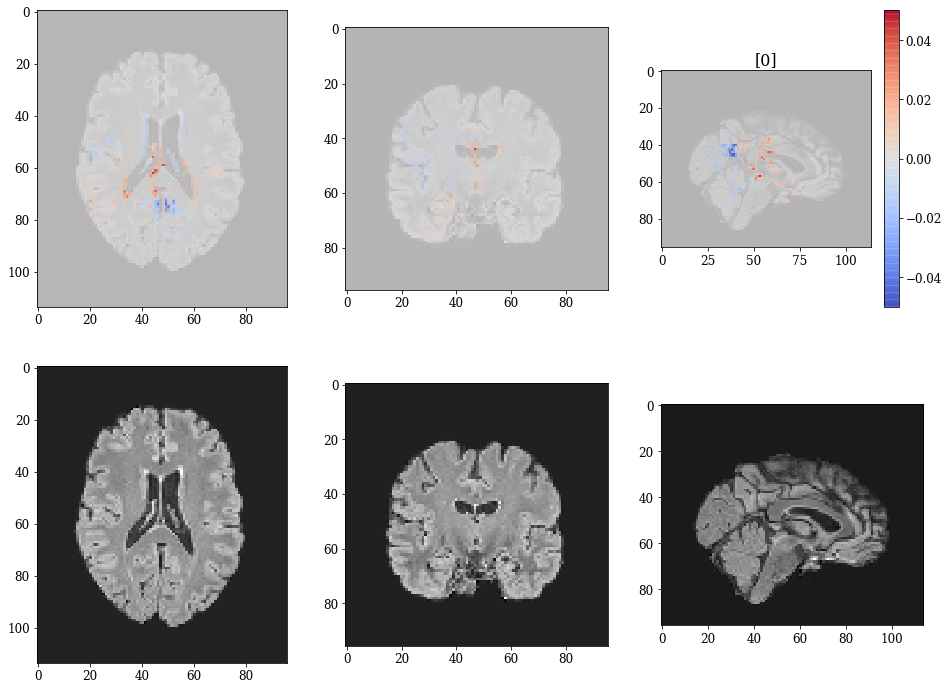

pred [1.] 
sigmoid score [0.99642295]
fine_tuned_beheaded score 5.629638
analysis sum 6.679100


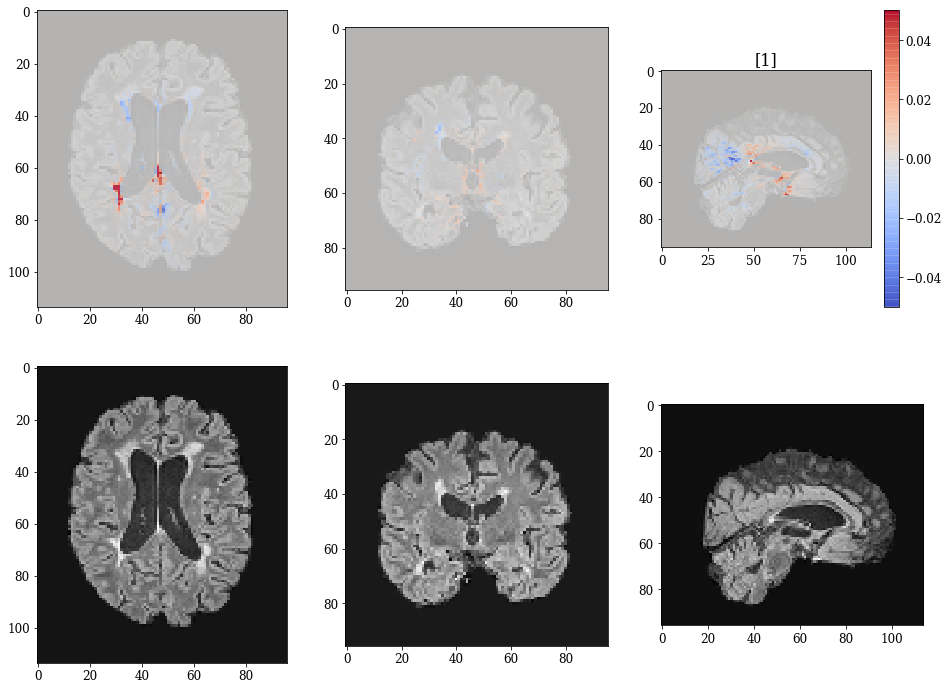

pred [0.] 
sigmoid score [0.34410045]
fine_tuned_beheaded score -0.645074
analysis sum -0.814156


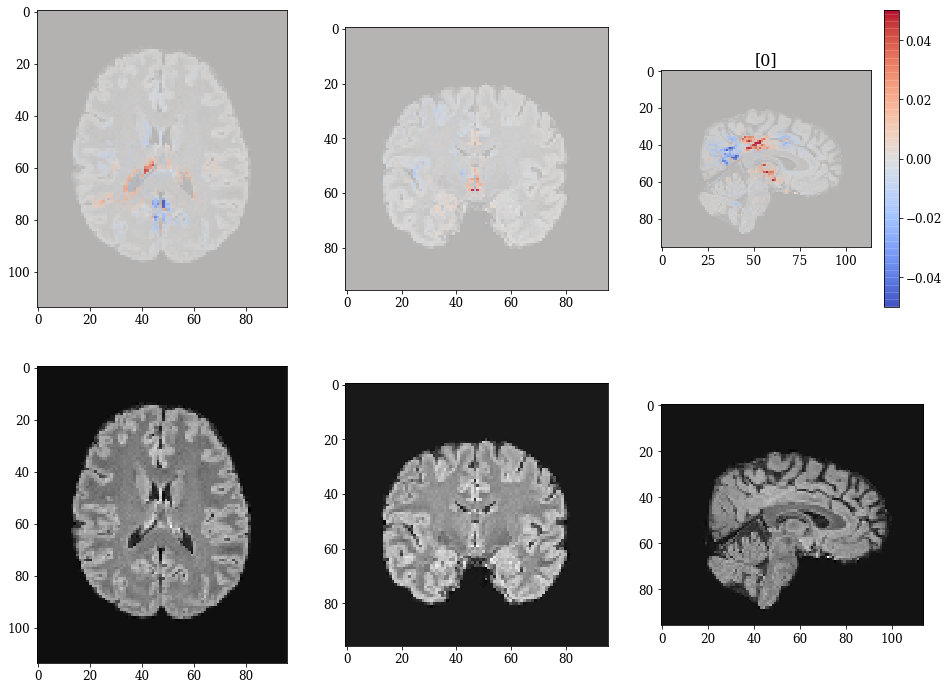

pred [1.] 
sigmoid score [0.97338426]
fine_tuned_beheaded score 3.599277
analysis sum 4.413380


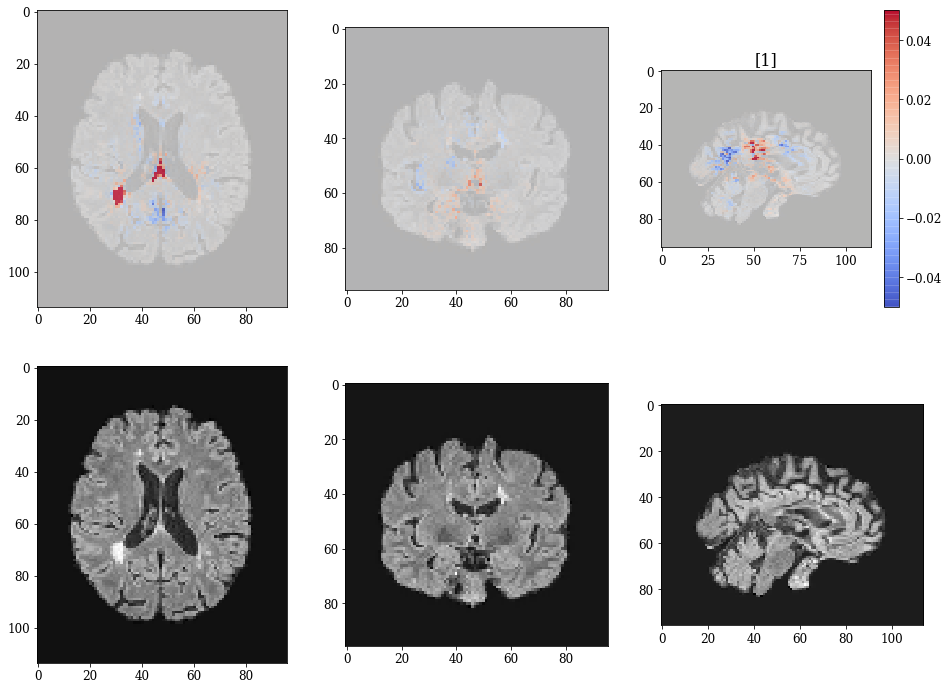

pred [1.] 
sigmoid score [0.8503438]
fine_tuned_beheaded score 1.737301
analysis sum 2.124648


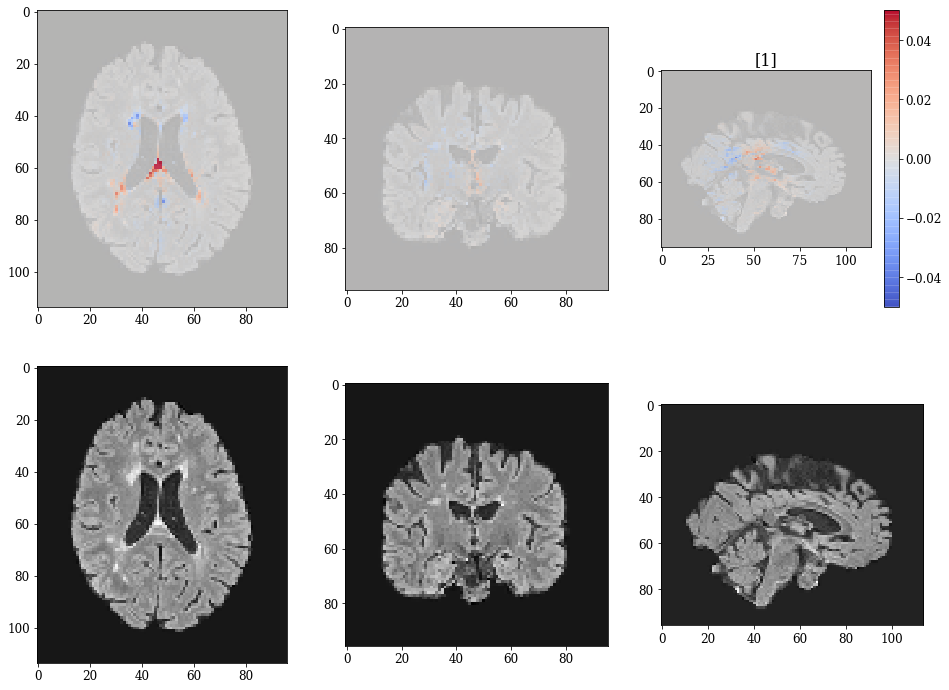

pred [0.] 
sigmoid score [0.39456418]
fine_tuned_beheaded score -0.428167
analysis sum -0.713911


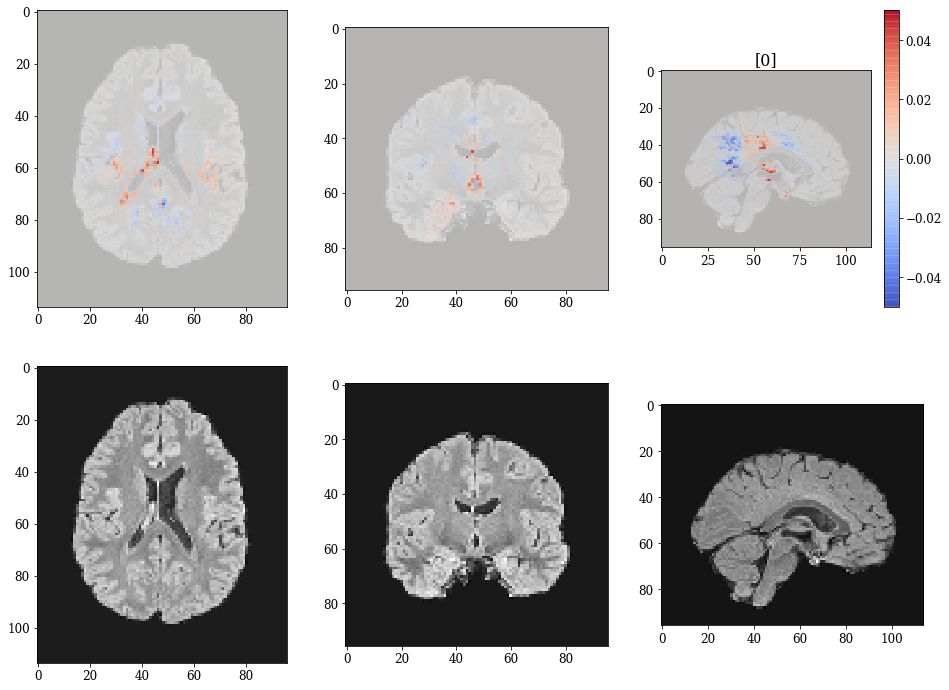

pred [1.] 
sigmoid score [0.8818087]
fine_tuned_beheaded score 2.009670
analysis sum 2.830436


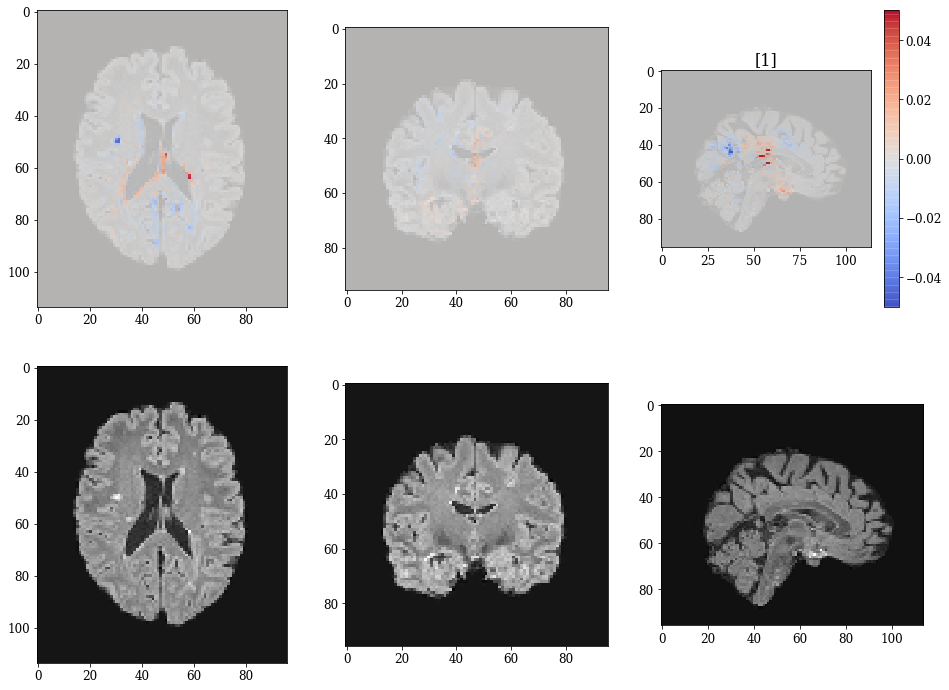

pred [1.] 
sigmoid score [0.9706222]
fine_tuned_beheaded score 3.497698
analysis sum 5.073508


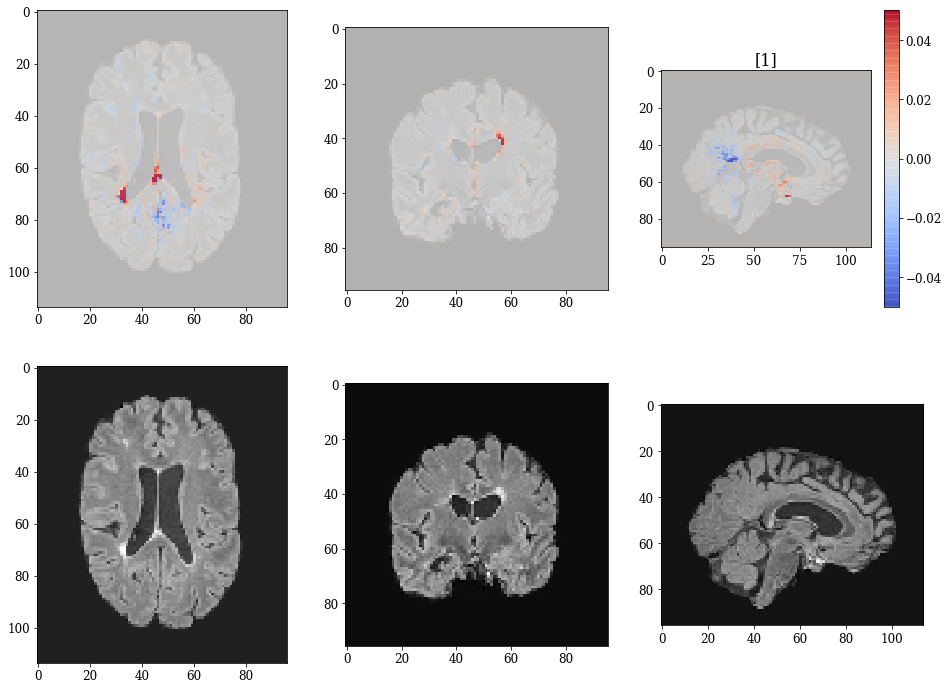

pred [1.] 
sigmoid score [0.728988]
fine_tuned_beheaded score 0.989494
analysis sum 1.226548


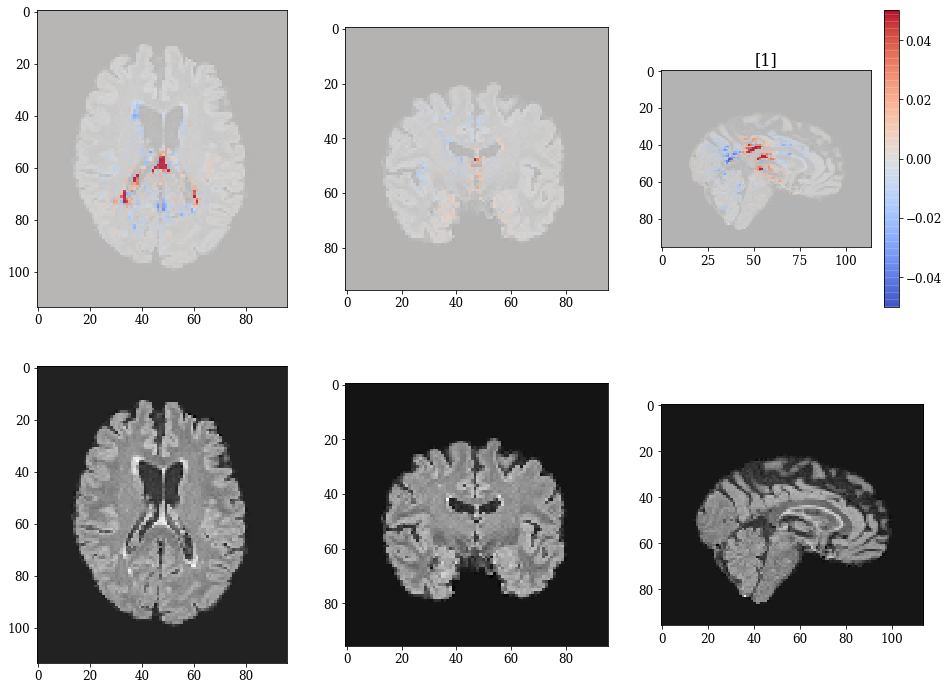

pred [1.] 
sigmoid score [0.9030025]
fine_tuned_beheaded score 2.231040
analysis sum 3.009447


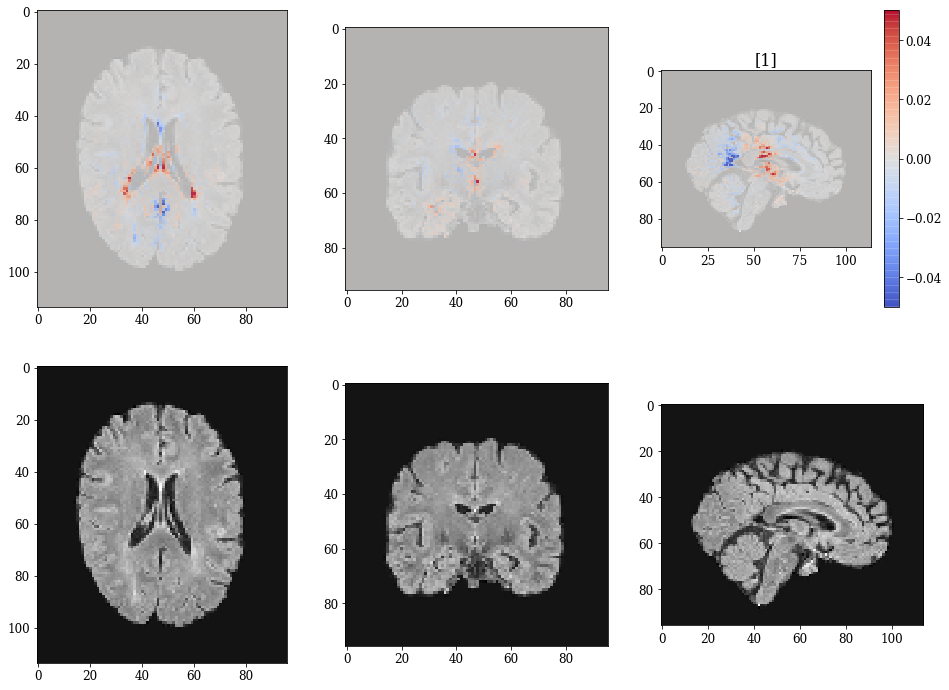

pred [0.] 
sigmoid score [0.36676332]
fine_tuned_beheaded score -0.546127
analysis sum -0.611051


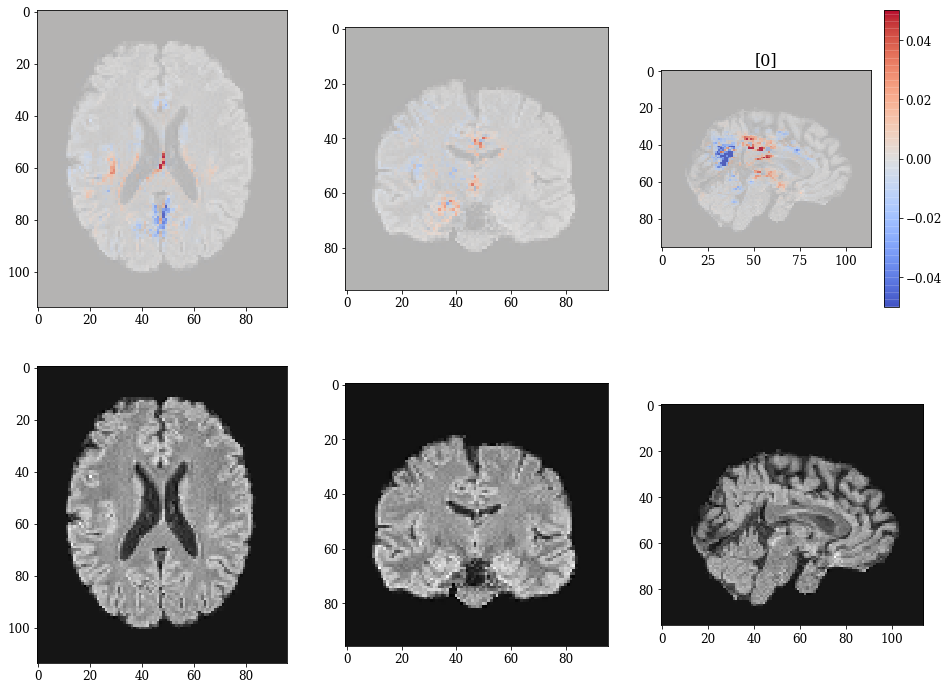

pred [1.] 
sigmoid score [0.6544661]
fine_tuned_beheaded score 0.638729
analysis sum 1.263523


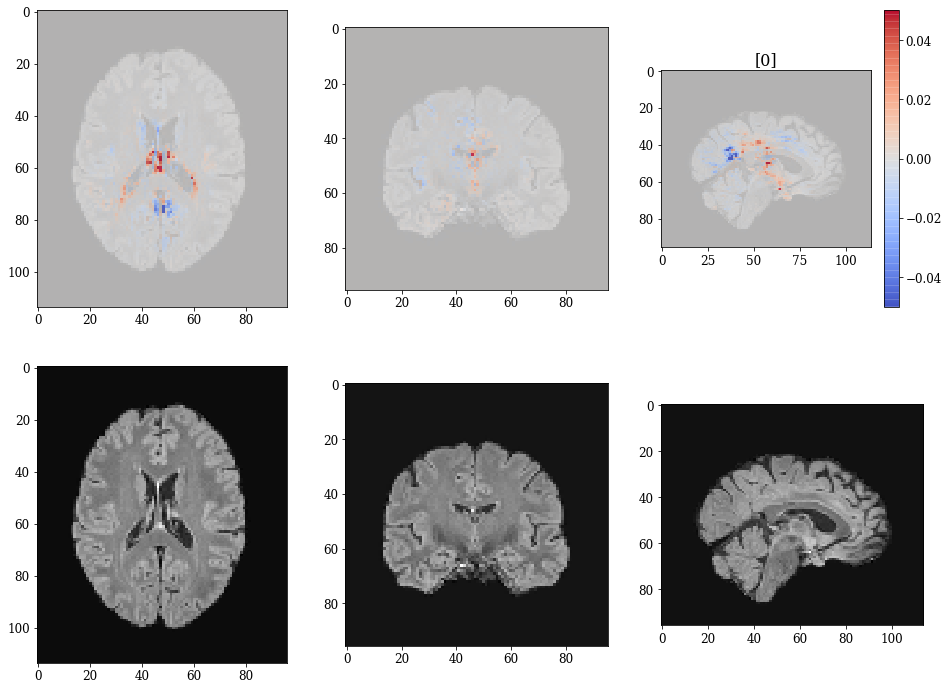

pred [0.] 
sigmoid score [0.27610388]
fine_tuned_beheaded score -0.963871
analysis sum -1.569888


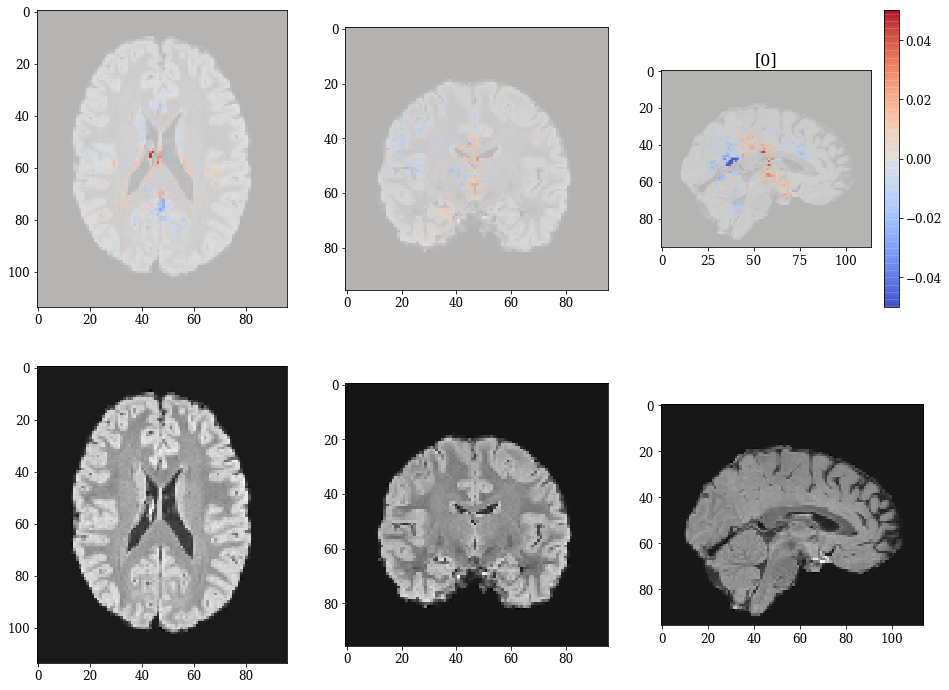

pred [1.] 
sigmoid score [0.9633791]
fine_tuned_beheaded score 3.269826
analysis sum 4.172566


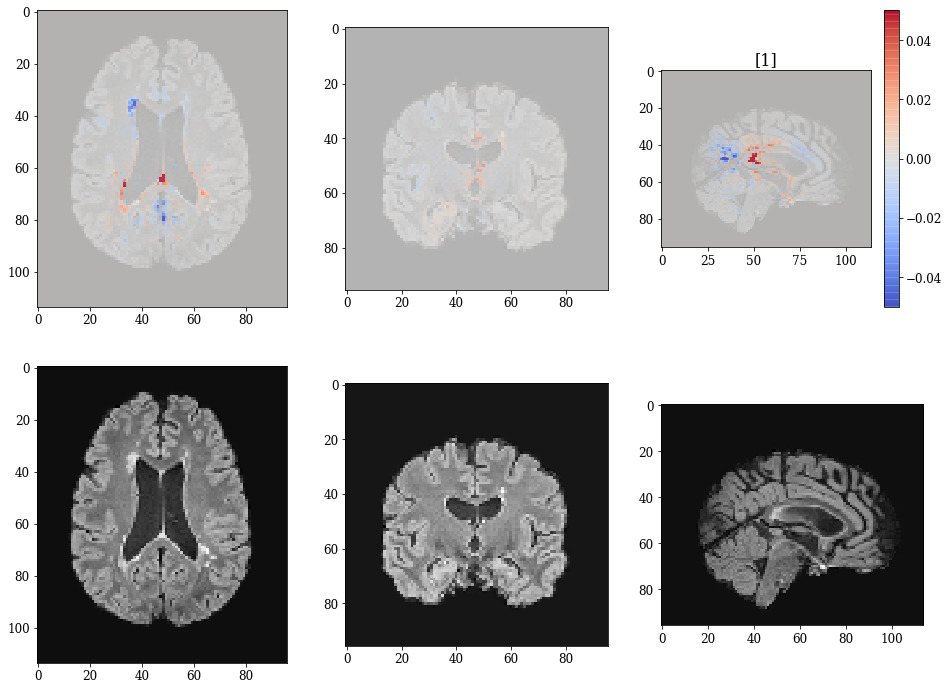

pred [0.] 
sigmoid score [0.09877317]
fine_tuned_beheaded score -2.210931
analysis sum -2.669526


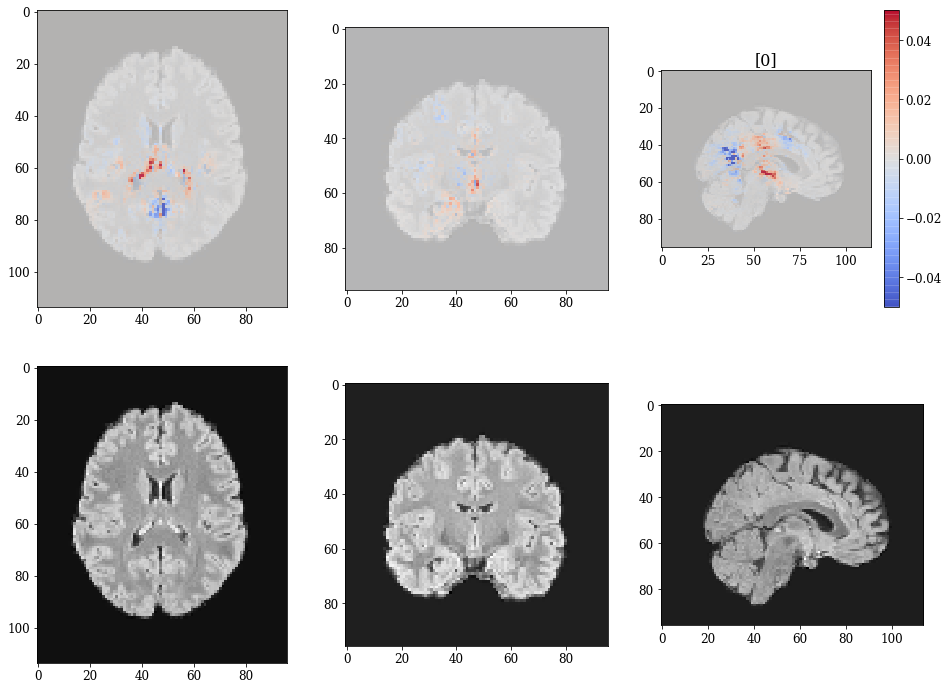

pred [0.] 
sigmoid score [0.27340817]
fine_tuned_beheaded score -0.977399
analysis sum -1.177915


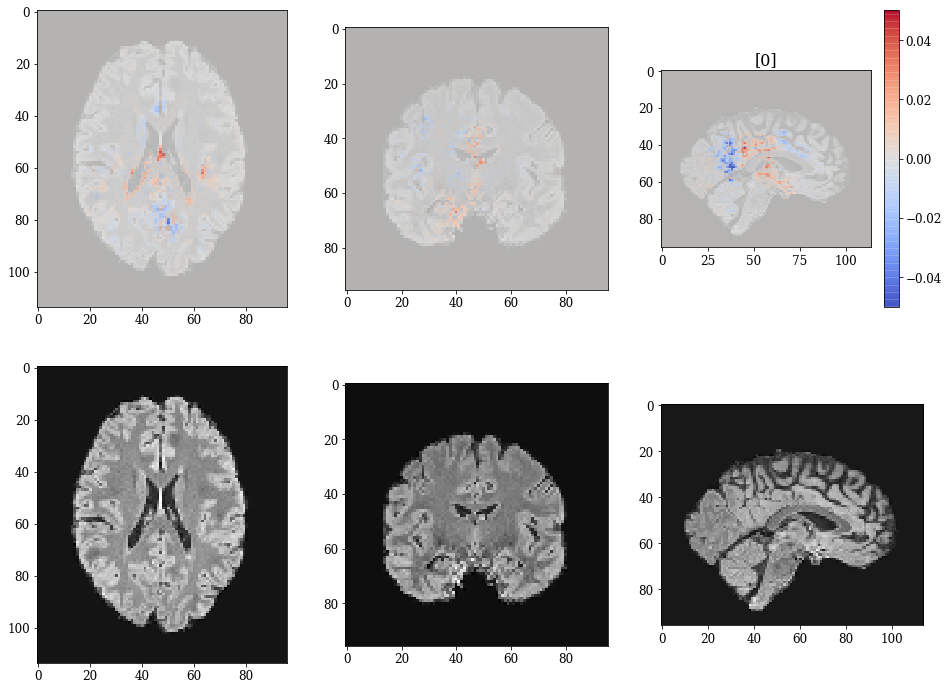

pred [1.] 
sigmoid score [0.86228323]
fine_tuned_beheaded score 1.834385
analysis sum 2.327687


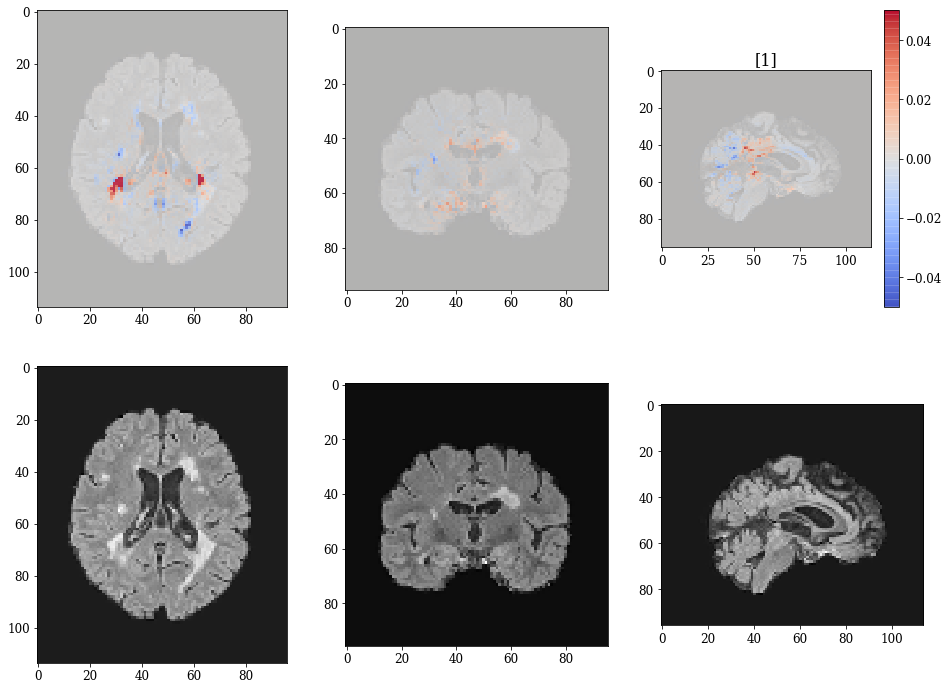

pred [0.] 
sigmoid score [0.45107046]
fine_tuned_beheaded score -0.196346
analysis sum 0.141053


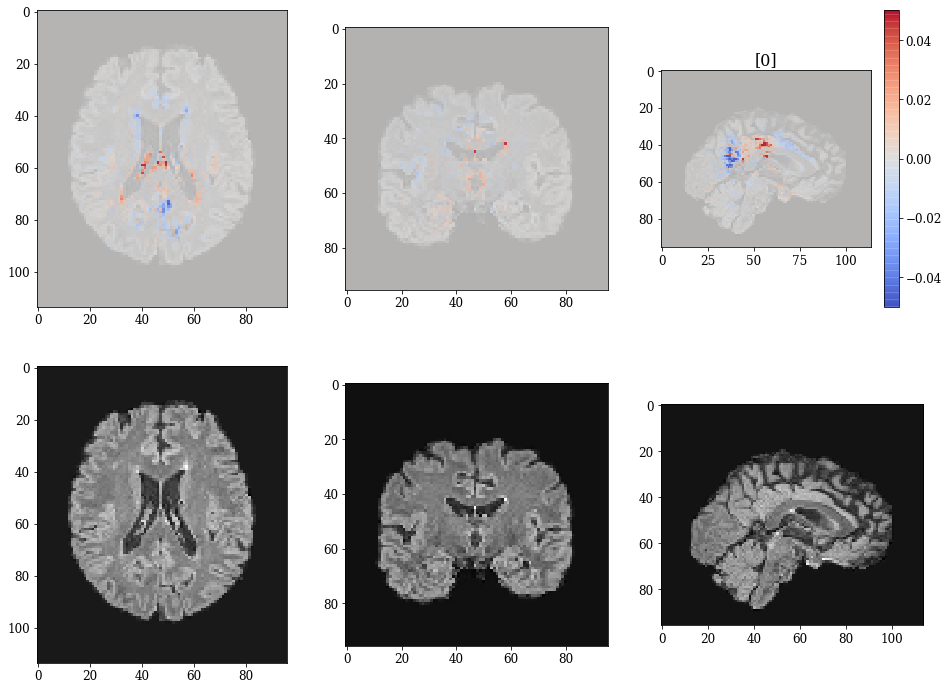

In [85]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", fine_tuned_beheaded_model)

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("fine_tuned_beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))
    plot_heatmap(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm')

# Averages pre-training vs scratch comparison

In [86]:
pre_trained_TP_heatmaps_holdout, pre_trained_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 0
zero 10


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [87]:
pre_trained_TP_heatmaps_train, pre_trained_TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 124
one 0
zero 61


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [88]:
fine_tuned_TP_heatmaps_holdout, fine_tuned_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [89]:
pre_trained_MS_heatmaps_holdout, pre_trained_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [90]:
fine_tuned_MS_heatmaps_holdout, fine_tuned_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [91]:
scratch_TP_heatmaps_holdout, scratch_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 6


In [92]:
scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [93]:
random_TP_heatmaps_holdout, random_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 0
zero 10


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [94]:
random_MS_heatmaps_holdout, random_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [95]:
def plot_heatmap_transfer_learning(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10., 4 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray')
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray')
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.07, 0.1, p2[2], 0.015]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)

    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [96]:
image_file_dir

'/analysis/fabiane/documents/publications/MS_CNN_VIS'

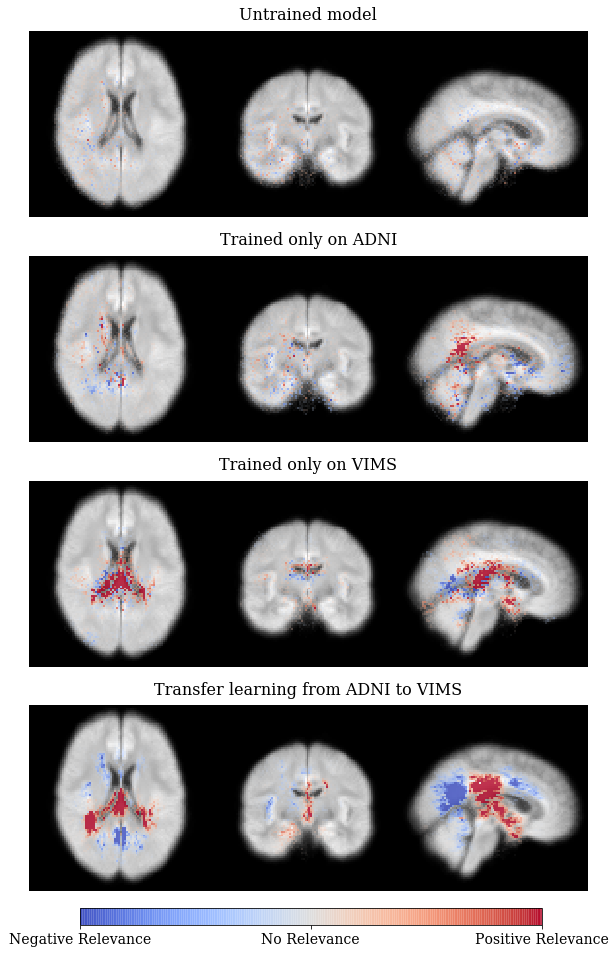

In [97]:
# use all classifications not just correct ones
hms = [random_MS_heatmaps_holdout * 20, pre_trained_MS_heatmaps_holdout * 20, scratch_MS_heatmaps_holdout, fine_tuned_MS_heatmaps_holdout]
titles = ["Untrained model", "Trained only on ADNI", "Trained only on VIMS", "Transfer learning from ADNI to VIMS"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_TransferLearning_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout * 15)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

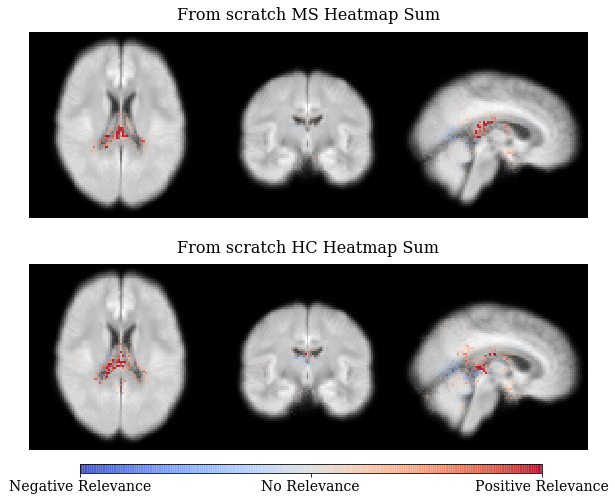

In [98]:
hms = [scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout]
titles = ["From scratch MS Heatmap Sum", "From scratch HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(scratch_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

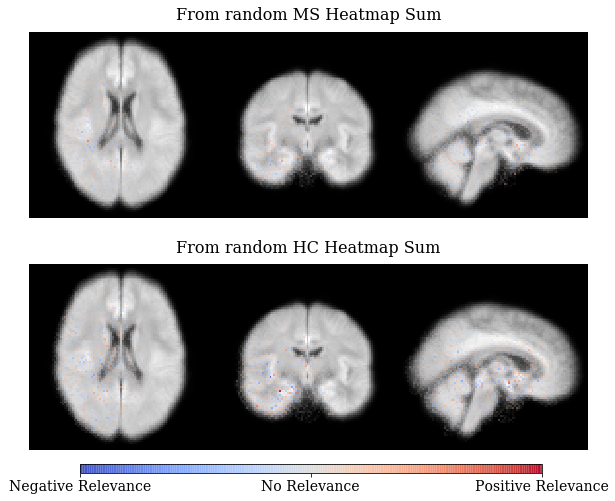

In [99]:
hms = [random_MS_heatmaps_holdout, random_HC_heatmaps_holdout]
titles = ["From random MS Heatmap Sum", "From random HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)